In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


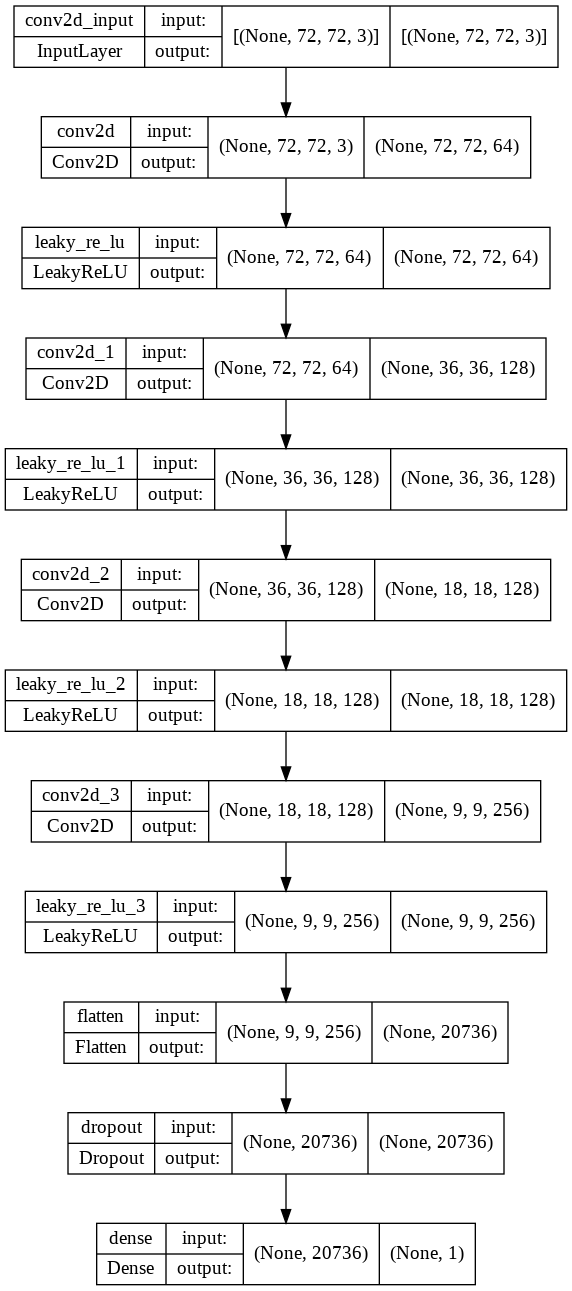

In [3]:
# Building the discriminator model
def build_discriminator(img_shape=(72, 72, 3)):
    model = Sequential()
    # Start with 72x72 image
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 36x36
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 18x18
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 9x9
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Binary classifier
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # Compile discriminator model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

# Build, compile and display a summary of the discriminator
discriminator = build_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=True)

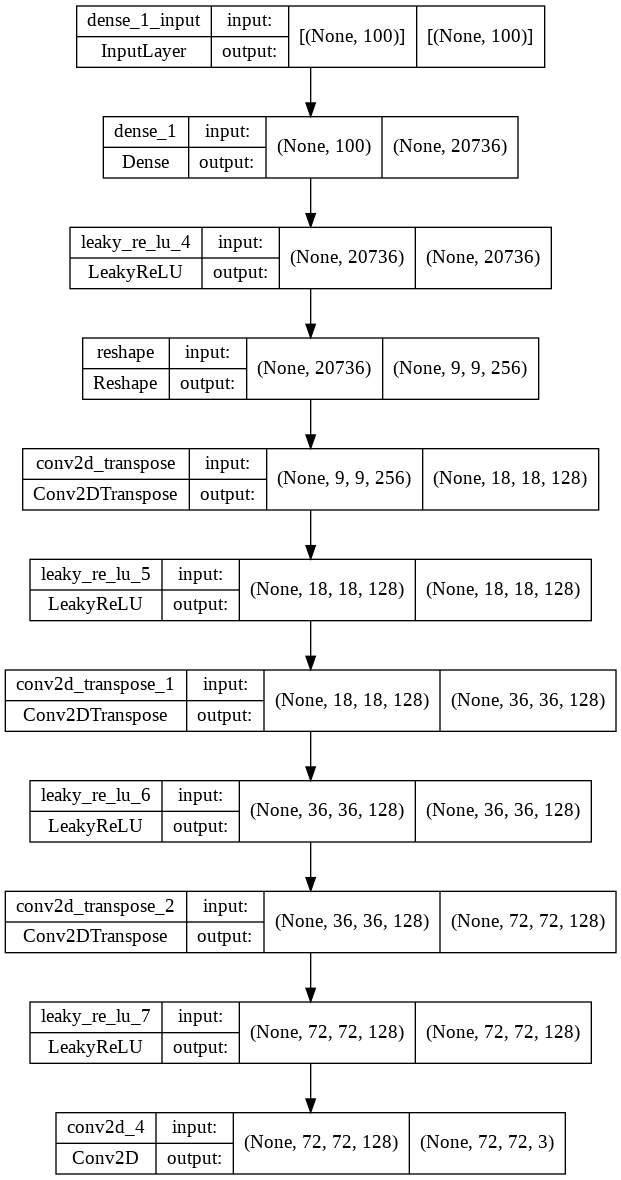

In [4]:
# Building the generator model
def build_generator(latent_dim):
    model = Sequential()
    # Start with 9x9 image
    model.add(Dense(256*9*9, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((9, 9, 256)))
    # Upsample to 18x18
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 36x36
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 72x72
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

    return model

# Size of the latent space
latent_dim = 100
# Build and display a summary of the discriminator
generator = build_generator(latent_dim)
plot_model(generator, show_shapes=True, show_layer_names=True)

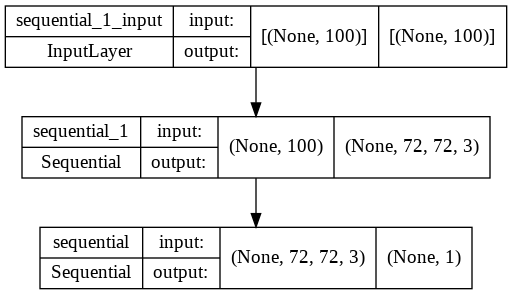

In [5]:
# Building the GAN model which combines the discriminator and generator models
def define_gan(generator, discriminator):
    # Set the weights in the discriminator to not trainable
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # Compile combined GAN model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    return model

# Build and display a summary of the GAN
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True, show_layer_names=True)

In [6]:
# Load and return the training data
def load_training_data():
    train_x = np.load(path + 'train_x10000x72.npy', allow_pickle=True)

    # Converting image data from doubles to floats
    train_x = train_x.astype('float32')
    # Scale from [0, 255] to [-1, 1]
    train_x = (train_x - 127.5) / 127.5

    return train_x

In [7]:
# Select random images from training data
def select_real_samples(train_x, n_samples):
    # Choose n_samples amount of random indexes
    random_indexes = np.random.randint(0, train_x.shape[0], n_samples)
    # Select the images from the training data
    real_samples_x = train_x[random_indexes]
    # Label '1' for each image to signify that it is real
    real_samples_y = np.ones((n_samples, 1))

    return real_samples_x, real_samples_y

In [8]:
# Generate random points in the latent space
def generate_latent_points(latent_dim, n_samples):
    # Choose n_samples amount of random points in the latent space
    fake_x_input = np.random.randn(latent_dim * n_samples)
    # Reshape into batches of inputs for the model
    fake_x_input = fake_x_input.reshape(n_samples, latent_dim)

    return fake_x_input

In [9]:
# Generate fake images using random points in the latent space
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generate random points in the latent space
    fake_x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake images
    fake_x = generator.predict(fake_x_input)
    # Label '0' for each image to signify that it is fake
    fake_y = np.zeros((n_samples, 1))

    return fake_x, fake_y

In [10]:
# Display and save a plot of n^2 generated images
def plot_gen_imgs(generated_imgs, epoch, n=4):
    # Scale from [-1, 1] to [0, 1] for displaying images
    generated_imgs = (generated_imgs + 1) / 2.0

    # Plot generated images in a grid
    fig, ax = plt.subplots(n, n, figsize=(2, 2))
    count = 0
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(generated_imgs[count])
            ax[i, j].axis('off')
            count += 1
    
    # Save the plot of generated images
    plt.savefig(path + '/GAN for 72x72 Output/generated_images_epoch_%d.jpg' % 
                (epoch+1), bbox_inches='tight', dpi = 200)
    plt.close()

In [11]:
# Save the generator model
def save_generator(generator, epoch):
    generator.save(path  + '/GAN for 72x72 Output/generator_model_epoch_%d.h5' % 
                   (epoch+1))

In [12]:
losses = []
accuracies = []
epochs = []

# Periodic evaluation of the model
def evaluate_gan(epoch, generator, discriminator, train_x, latent_dim, n_samples=150):
    # Evaluate discriminator on real images
    real_x, real_y = select_real_samples(train_x, n_samples)
    _, d_acc_real = discriminator.evaluate(real_x, real_y, verbose=0)

    # Evaluate discriminator on fake images
    fake_x, fake_y = generate_fake_samples(generator, latent_dim, n_samples)
    _, d_acc_fake = discriminator.evaluate(fake_x, fake_y, verbose=0)

    print('\nDiscriminator Accuracy (Real Data): %.0f%%, Discriminator Accuracy (Fake Data): %.0f%%\n' % 
          (d_acc_real*100, d_acc_fake*100))
    
    plot_gen_imgs(fake_x, epoch)
    save_generator(generator, epoch)

In [13]:
# Display and save plots to show discriminator loss and accuracy throughout training
def plot_loss_and_accuracy(losses, accuracies, epochs):
    losses = np.array(losses)
    accuracies = np.array(accuracies)
    epochs = np.array(epochs)

    # Plot training losses for Discriminator
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, losses.T[0], label='Discriminator Loss (Real Data)')
    plt.plot(epochs, losses.T[1], label='Discriminator Loss (Fake Data)')

    # Calculate line of best fit
    a0, a1 = np.polyfit(epochs, losses.T[0], 1)
    b0, b1 = np.polyfit(epochs, losses.T[1], 1)

    # Plot line of best fit
    plt.plot(epochs, a0*epochs + a1, color='blue', linestyle='dashed', 
              label='Line of best fit Discriminator Loss (Real Data)')
    plt.plot(epochs, b0*epochs + b1, color='red', linestyle='dashed', 
              label='Line of best fit Discriminator Loss (Fake Data)')

    # Configure and save plot
    plt.xticks(np.arange(0, np.max(epochs) + 1, epochs.shape[0] / 20))
    plt.title('Discriminator Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    plt.xlim([0, np.max(epochs) + 1])
    plt.ylim()
    plt.legend()
    plt.savefig(path + '/GAN for 28x28 Output/discriminator_loss_plot.jpg', 
                bbox_inches='tight')


    # Plot training accuracies for Discriminator
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, accuracies.T[0], label='Discriminator Accuracy (Real Data)')
    plt.plot(epochs, accuracies.T[1], label='Discriminator Accuracy (Fake Data)')

    # Calculate line of best fit
    c0, c1 = np.polyfit(epochs, accuracies.T[0], 1)
    d0, d1 = np.polyfit(epochs, accuracies.T[1], 1)

    # Plot line of best fit
    plt.plot(epochs, c0*epochs + c1, color='blue', linestyle='dashed', 
              label='Line of best fit (Real Data)')
    plt.plot(epochs, d0*epochs + d1, color='red', linestyle='dashed', 
              label='Line of best fit (Fake Data)')

    # Configure and save plot
    plt.xticks(np.arange(0, np.max(epochs) + 1, epochs.shape[0] / 20))
    plt.title('Discriminator Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Values (%)')
    plt.xlim([0, np.max(epochs) + 1])
    plt.ylim([0, 110])
    plt.legend()
    plt.savefig(path + '/GAN for 28x28 Output/discriminator_accuracy_plot.jpg', 
                bbox_inches='tight')

Epoch 1/1000: 100%|██████████| 78/78 [00:31<00:00,  2.50it/s]


Discriminator Loss (Real Data): 0.219, Discriminator Loss (Fake Data): 0.637, Generator Loss: 1.122


Epoch 2/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.035, Discriminator Loss (Fake Data): 0.043, Generator Loss: 4.072


Epoch 3/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.256, Discriminator Loss (Fake Data): 0.081, Generator Loss: 3.460


Epoch 4/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.805, Discriminator Loss (Fake Data): 0.702, Generator Loss: 1.140


Epoch 5/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.686, Generator Loss: 1.001


Epoch 6/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.654, Discriminator Loss (Fake Data): 0.646, Generator Loss: 0.957


Epoch 7/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.603, Discriminator Loss (Fake Data): 0.620, Generator Loss: 1.012


Epoch 8/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.665, Generator Loss: 0.954


Epoch 9/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.651, Discriminator Loss (Fake Data): 0.665, Generator Loss: 0.932


Epoch 10/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.631, Discriminator Loss (Fake Data): 0.692, Generator Loss: 0.902

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 89%



Epoch 11/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.634, Generator Loss: 0.967


Epoch 12/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.546, Discriminator Loss (Fake Data): 0.569, Generator Loss: 1.126


Epoch 13/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.298


Epoch 14/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.467, Discriminator Loss (Fake Data): 0.468, Generator Loss: 1.685


Epoch 15/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.513, Discriminator Loss (Fake Data): 0.639, Generator Loss: 1.394


Epoch 16/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.598, Generator Loss: 1.231


Epoch 17/1000: 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.504, Generator Loss: 1.591


Epoch 18/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.350


Epoch 19/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.512, Discriminator Loss (Fake Data): 0.528, Generator Loss: 1.510


Epoch 20/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.649, Discriminator Loss (Fake Data): 0.537, Generator Loss: 1.286

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 93%



Epoch 21/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.649, Discriminator Loss (Fake Data): 0.537, Generator Loss: 1.237


Epoch 22/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.689, Discriminator Loss (Fake Data): 0.447, Generator Loss: 1.683


Epoch 23/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.605, Generator Loss: 1.380


Epoch 24/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.539, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.350


Epoch 25/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.592, Discriminator Loss (Fake Data): 0.485, Generator Loss: 1.187


Epoch 26/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.588, Generator Loss: 1.206


Epoch 27/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.536, Discriminator Loss (Fake Data): 0.713, Generator Loss: 1.302


Epoch 28/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.301


Epoch 29/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.325


Epoch 30/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.679, Discriminator Loss (Fake Data): 0.508, Generator Loss: 1.490

Discriminator Accuracy (Real Data): 81%, Discriminator Accuracy (Fake Data): 85%



Epoch 31/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.631, Generator Loss: 1.271


Epoch 32/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.309


Epoch 33/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.617, Generator Loss: 1.285


Epoch 34/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.687, Generator Loss: 1.319


Epoch 35/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.513, Generator Loss: 1.344


Epoch 36/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.798


Epoch 37/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.542, Generator Loss: 1.874


Epoch 38/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.499, Generator Loss: 1.397


Epoch 39/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.436


Epoch 40/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.477, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.377

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 90%



Epoch 41/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.465, Discriminator Loss (Fake Data): 0.592, Generator Loss: 1.460


Epoch 42/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.543, Generator Loss: 1.514


Epoch 43/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.351


Epoch 44/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.632, Generator Loss: 1.267


Epoch 45/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.509, Generator Loss: 1.212


Epoch 46/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.511, Generator Loss: 1.395


Epoch 47/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.494, Discriminator Loss (Fake Data): 0.556, Generator Loss: 1.505


Epoch 48/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.623, Discriminator Loss (Fake Data): 0.492, Generator Loss: 1.381


Epoch 49/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.559, Discriminator Loss (Fake Data): 0.607, Generator Loss: 1.325


Epoch 50/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.446

Discriminator Accuracy (Real Data): 52%, Discriminator Accuracy (Fake Data): 95%



Epoch 51/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.548, Discriminator Loss (Fake Data): 0.511, Generator Loss: 1.348


Epoch 52/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.486


Epoch 53/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.792, Generator Loss: 1.196


Epoch 54/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.643, Discriminator Loss (Fake Data): 0.686, Generator Loss: 1.325


Epoch 55/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.510, Generator Loss: 1.214


Epoch 56/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.570, Discriminator Loss (Fake Data): 0.692, Generator Loss: 1.251


Epoch 57/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.450, Discriminator Loss (Fake Data): 0.450, Generator Loss: 1.530


Epoch 58/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.664, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.139


Epoch 59/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.656, Discriminator Loss (Fake Data): 0.638, Generator Loss: 1.470


Epoch 60/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.568, Generator Loss: 1.463

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 95%



Epoch 61/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.458, Discriminator Loss (Fake Data): 0.596, Generator Loss: 1.434


Epoch 62/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.475, Discriminator Loss (Fake Data): 0.504, Generator Loss: 1.526


Epoch 63/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.457


Epoch 64/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.497, Discriminator Loss (Fake Data): 0.540, Generator Loss: 1.782


Epoch 65/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.557, Generator Loss: 1.339


Epoch 66/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.534, Generator Loss: 1.425


Epoch 67/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.529, Generator Loss: 1.315


Epoch 68/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.510


Epoch 69/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.515, Generator Loss: 1.204


Epoch 70/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.525, Discriminator Loss (Fake Data): 0.525, Generator Loss: 1.462

Discriminator Accuracy (Real Data): 64%, Discriminator Accuracy (Fake Data): 92%



Epoch 71/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.558, Discriminator Loss (Fake Data): 0.562, Generator Loss: 1.290


Epoch 72/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.430


Epoch 73/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.539, Discriminator Loss (Fake Data): 0.606, Generator Loss: 1.329


Epoch 74/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.704, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.254


Epoch 75/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.507, Generator Loss: 1.347


Epoch 76/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.610, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.139


Epoch 77/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.508, Generator Loss: 1.365


Epoch 78/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.294


Epoch 79/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.593, Generator Loss: 1.139


Epoch 80/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.765, Discriminator Loss (Fake Data): 0.524, Generator Loss: 1.336

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 91%



Epoch 81/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.562, Discriminator Loss (Fake Data): 0.537, Generator Loss: 1.408


Epoch 82/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.603, Discriminator Loss (Fake Data): 0.562, Generator Loss: 1.473


Epoch 83/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.699, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.264


Epoch 84/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.621, Discriminator Loss (Fake Data): 0.553, Generator Loss: 1.299


Epoch 85/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.415


Epoch 86/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.614, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.536


Epoch 87/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.467, Generator Loss: 1.308


Epoch 88/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.186


Epoch 89/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.633, Discriminator Loss (Fake Data): 0.518, Generator Loss: 1.249


Epoch 90/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.570, Discriminator Loss (Fake Data): 0.586, Generator Loss: 1.402

Discriminator Accuracy (Real Data): 65%, Discriminator Accuracy (Fake Data): 91%



Epoch 91/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.604, Discriminator Loss (Fake Data): 0.474, Generator Loss: 1.425


Epoch 92/1000: 100%|██████████| 78/78 [00:21<00:00,  3.69it/s]


Discriminator Loss (Real Data): 0.557, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.400


Epoch 93/1000: 100%|██████████| 78/78 [00:21<00:00,  3.67it/s]


Discriminator Loss (Real Data): 0.647, Discriminator Loss (Fake Data): 0.482, Generator Loss: 1.390


Epoch 94/1000: 100%|██████████| 78/78 [00:21<00:00,  3.70it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.319


Epoch 95/1000: 100%|██████████| 78/78 [00:21<00:00,  3.69it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.507, Generator Loss: 1.378


Epoch 96/1000: 100%|██████████| 78/78 [00:20<00:00,  3.74it/s]


Discriminator Loss (Real Data): 0.648, Discriminator Loss (Fake Data): 0.518, Generator Loss: 1.334


Epoch 97/1000: 100%|██████████| 78/78 [00:20<00:00,  3.72it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.509, Generator Loss: 1.403


Epoch 98/1000: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.581, Generator Loss: 1.529


Epoch 99/1000: 100%|██████████| 78/78 [00:21<00:00,  3.63it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.609, Generator Loss: 1.166


Epoch 100/1000: 100%|██████████| 78/78 [00:21<00:00,  3.59it/s]


Discriminator Loss (Real Data): 0.575, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.431

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 92%



Epoch 101/1000: 100%|██████████| 78/78 [00:21<00:00,  3.58it/s]


Discriminator Loss (Real Data): 0.611, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.273


Epoch 102/1000: 100%|██████████| 78/78 [00:21<00:00,  3.60it/s]


Discriminator Loss (Real Data): 0.609, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.292


Epoch 103/1000: 100%|██████████| 78/78 [00:21<00:00,  3.65it/s]


Discriminator Loss (Real Data): 0.512, Discriminator Loss (Fake Data): 0.554, Generator Loss: 1.289


Epoch 104/1000: 100%|██████████| 78/78 [00:21<00:00,  3.69it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.535, Generator Loss: 1.357


Epoch 105/1000: 100%|██████████| 78/78 [00:20<00:00,  3.72it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.265


Epoch 106/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.527, Discriminator Loss (Fake Data): 0.493, Generator Loss: 1.318


Epoch 107/1000: 100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Discriminator Loss (Real Data): 0.598, Discriminator Loss (Fake Data): 0.594, Generator Loss: 1.194


Epoch 108/1000: 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Discriminator Loss (Real Data): 0.626, Discriminator Loss (Fake Data): 0.482, Generator Loss: 1.249


Epoch 109/1000: 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Discriminator Loss (Real Data): 0.640, Discriminator Loss (Fake Data): 0.491, Generator Loss: 1.295


Epoch 110/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.624, Discriminator Loss (Fake Data): 0.534, Generator Loss: 1.256

Discriminator Accuracy (Real Data): 45%, Discriminator Accuracy (Fake Data): 91%



Epoch 111/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.571, Discriminator Loss (Fake Data): 0.640, Generator Loss: 1.251


Epoch 112/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.633, Discriminator Loss (Fake Data): 0.550, Generator Loss: 1.429


Epoch 113/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.565, Discriminator Loss (Fake Data): 0.495, Generator Loss: 1.576


Epoch 114/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.563, Discriminator Loss (Fake Data): 0.513, Generator Loss: 1.256


Epoch 115/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.454, Discriminator Loss (Fake Data): 0.498, Generator Loss: 1.322


Epoch 116/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.504, Discriminator Loss (Fake Data): 0.474, Generator Loss: 1.439


Epoch 117/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.573, Generator Loss: 1.322


Epoch 118/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.579, Generator Loss: 1.169


Epoch 119/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.573, Discriminator Loss (Fake Data): 0.561, Generator Loss: 1.284


Epoch 120/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.570, Discriminator Loss (Fake Data): 0.582, Generator Loss: 1.514

Discriminator Accuracy (Real Data): 51%, Discriminator Accuracy (Fake Data): 90%



Epoch 121/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.645, Discriminator Loss (Fake Data): 0.532, Generator Loss: 1.252


Epoch 122/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.516, Generator Loss: 1.427


Epoch 123/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.668, Discriminator Loss (Fake Data): 0.538, Generator Loss: 1.319


Epoch 124/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.556, Discriminator Loss (Fake Data): 0.494, Generator Loss: 1.402


Epoch 125/1000: 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.515, Generator Loss: 1.350


Epoch 126/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.558, Discriminator Loss (Fake Data): 0.548, Generator Loss: 1.354


Epoch 127/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.469, Generator Loss: 1.482


Epoch 128/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.659, Generator Loss: 1.210


Epoch 129/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.586, Discriminator Loss (Fake Data): 0.595, Generator Loss: 1.396


Epoch 130/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.537, Discriminator Loss (Fake Data): 0.529, Generator Loss: 1.311

Discriminator Accuracy (Real Data): 57%, Discriminator Accuracy (Fake Data): 90%



Epoch 131/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.597, Discriminator Loss (Fake Data): 0.530, Generator Loss: 1.609


Epoch 132/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.529, Discriminator Loss (Fake Data): 0.533, Generator Loss: 1.451


Epoch 133/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.653, Discriminator Loss (Fake Data): 0.481, Generator Loss: 1.468


Epoch 134/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.600, Discriminator Loss (Fake Data): 0.495, Generator Loss: 1.439


Epoch 135/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.545, Generator Loss: 1.375


Epoch 136/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.392


Epoch 137/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.480, Discriminator Loss (Fake Data): 0.423, Generator Loss: 1.382


Epoch 138/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.651, Discriminator Loss (Fake Data): 0.531, Generator Loss: 1.276


Epoch 139/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.488, Generator Loss: 1.344


Epoch 140/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.530, Generator Loss: 1.359

Discriminator Accuracy (Real Data): 56%, Discriminator Accuracy (Fake Data): 94%



Epoch 141/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.582, Discriminator Loss (Fake Data): 0.471, Generator Loss: 1.562


Epoch 142/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.550, Discriminator Loss (Fake Data): 0.578, Generator Loss: 1.192


Epoch 143/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.509, Discriminator Loss (Fake Data): 0.525, Generator Loss: 1.223


Epoch 144/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.577, Discriminator Loss (Fake Data): 0.528, Generator Loss: 1.214


Epoch 145/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.435, Discriminator Loss (Fake Data): 0.542, Generator Loss: 1.317


Epoch 146/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.503, Discriminator Loss (Fake Data): 0.615, Generator Loss: 1.284


Epoch 147/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.555, Discriminator Loss (Fake Data): 0.518, Generator Loss: 1.573


Epoch 148/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.487, Discriminator Loss (Fake Data): 0.470, Generator Loss: 1.448


Epoch 149/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.650, Discriminator Loss (Fake Data): 0.526, Generator Loss: 1.345


Epoch 150/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.667, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.340

Discriminator Accuracy (Real Data): 60%, Discriminator Accuracy (Fake Data): 92%



Epoch 151/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.505, Generator Loss: 1.500


Epoch 152/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.506, Discriminator Loss (Fake Data): 0.408, Generator Loss: 1.476


Epoch 153/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.622, Discriminator Loss (Fake Data): 0.519, Generator Loss: 1.409


Epoch 154/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.507, Discriminator Loss (Fake Data): 0.563, Generator Loss: 1.233


Epoch 155/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.499, Discriminator Loss (Fake Data): 0.430, Generator Loss: 1.332


Epoch 156/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.576, Discriminator Loss (Fake Data): 0.585, Generator Loss: 1.492


Epoch 157/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.585, Discriminator Loss (Fake Data): 0.587, Generator Loss: 1.206


Epoch 158/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.548, Discriminator Loss (Fake Data): 0.516, Generator Loss: 1.325


Epoch 159/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.629, Discriminator Loss (Fake Data): 0.543, Generator Loss: 1.160


Epoch 160/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.468, Generator Loss: 1.372

Discriminator Accuracy (Real Data): 53%, Discriminator Accuracy (Fake Data): 91%



Epoch 161/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.554, Discriminator Loss (Fake Data): 0.511, Generator Loss: 1.343


Epoch 162/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.515, Discriminator Loss (Fake Data): 0.493, Generator Loss: 1.390


Epoch 163/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.405, Discriminator Loss (Fake Data): 0.497, Generator Loss: 1.556


Epoch 164/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.504, Generator Loss: 1.498


Epoch 165/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.617, Discriminator Loss (Fake Data): 0.477, Generator Loss: 1.343


Epoch 166/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.632, Discriminator Loss (Fake Data): 0.558, Generator Loss: 1.298


Epoch 167/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.484, Discriminator Loss (Fake Data): 0.436, Generator Loss: 1.434


Epoch 168/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.662, Discriminator Loss (Fake Data): 0.552, Generator Loss: 1.270


Epoch 169/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.574, Discriminator Loss (Fake Data): 0.506, Generator Loss: 1.613


Epoch 170/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.466, Discriminator Loss (Fake Data): 0.541, Generator Loss: 1.472

Discriminator Accuracy (Real Data): 60%, Discriminator Accuracy (Fake Data): 87%



Epoch 171/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.542, Discriminator Loss (Fake Data): 0.503, Generator Loss: 1.659


Epoch 172/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.641, Generator Loss: 1.000


Epoch 173/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.637, Discriminator Loss (Fake Data): 0.533, Generator Loss: 1.490


Epoch 174/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.517, Discriminator Loss (Fake Data): 0.489, Generator Loss: 1.306


Epoch 175/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.616, Discriminator Loss (Fake Data): 0.520, Generator Loss: 1.507


Epoch 176/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.543, Discriminator Loss (Fake Data): 0.445, Generator Loss: 1.706


Epoch 177/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.393, Discriminator Loss (Fake Data): 0.515, Generator Loss: 1.571


Epoch 178/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.525, Discriminator Loss (Fake Data): 0.403, Generator Loss: 2.082


Epoch 179/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.599, Discriminator Loss (Fake Data): 0.258, Generator Loss: 2.446


Epoch 180/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.281, Discriminator Loss (Fake Data): 0.409, Generator Loss: 1.989

Discriminator Accuracy (Real Data): 66%, Discriminator Accuracy (Fake Data): 88%



Epoch 181/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.628, Discriminator Loss (Fake Data): 0.548, Generator Loss: 1.708


Epoch 182/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.466, Discriminator Loss (Fake Data): 0.497, Generator Loss: 1.938


Epoch 183/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.634, Discriminator Loss (Fake Data): 0.469, Generator Loss: 1.988


Epoch 184/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.267, Discriminator Loss (Fake Data): 0.442, Generator Loss: 2.539


Epoch 185/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.421, Generator Loss: 2.588


Epoch 186/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.252, Discriminator Loss (Fake Data): 0.399, Generator Loss: 2.529


Epoch 187/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.354, Discriminator Loss (Fake Data): 0.411, Generator Loss: 2.367


Epoch 188/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.474, Discriminator Loss (Fake Data): 0.469, Generator Loss: 2.195


Epoch 189/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.436, Generator Loss: 2.200


Epoch 190/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.605, Discriminator Loss (Fake Data): 0.254, Generator Loss: 2.405

Discriminator Accuracy (Real Data): 100%, Discriminator Accuracy (Fake Data): 83%



Epoch 191/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.478, Discriminator Loss (Fake Data): 0.459, Generator Loss: 2.503


Epoch 192/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.410, Discriminator Loss (Fake Data): 0.344, Generator Loss: 2.228


Epoch 193/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.496, Discriminator Loss (Fake Data): 0.565, Generator Loss: 1.940


Epoch 194/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.678, Discriminator Loss (Fake Data): 0.256, Generator Loss: 2.848


Epoch 195/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.376, Generator Loss: 2.927


Epoch 196/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.325, Discriminator Loss (Fake Data): 0.358, Generator Loss: 2.689


Epoch 197/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.459, Generator Loss: 2.010


Epoch 198/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.504, Discriminator Loss (Fake Data): 0.395, Generator Loss: 2.475


Epoch 199/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.464, Discriminator Loss (Fake Data): 0.404, Generator Loss: 2.560


Epoch 200/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.468, Discriminator Loss (Fake Data): 0.338, Generator Loss: 2.594

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 79%



Epoch 201/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.368, Discriminator Loss (Fake Data): 0.352, Generator Loss: 2.810


Epoch 202/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.276, Generator Loss: 2.766


Epoch 203/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.477, Discriminator Loss (Fake Data): 0.635, Generator Loss: 2.423


Epoch 204/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.387, Discriminator Loss (Fake Data): 0.504, Generator Loss: 2.061


Epoch 205/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.382, Discriminator Loss (Fake Data): 0.479, Generator Loss: 2.634


Epoch 206/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.397, Discriminator Loss (Fake Data): 0.374, Generator Loss: 2.642


Epoch 207/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.375, Discriminator Loss (Fake Data): 0.487, Generator Loss: 2.606


Epoch 208/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.335, Generator Loss: 2.514


Epoch 209/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.415, Generator Loss: 2.599


Epoch 210/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.282, Discriminator Loss (Fake Data): 0.398, Generator Loss: 2.529

Discriminator Accuracy (Real Data): 71%, Discriminator Accuracy (Fake Data): 98%



Epoch 211/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.293, Discriminator Loss (Fake Data): 0.479, Generator Loss: 2.096


Epoch 212/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.530, Discriminator Loss (Fake Data): 0.406, Generator Loss: 2.261


Epoch 213/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.377, Discriminator Loss (Fake Data): 0.309, Generator Loss: 2.291


Epoch 214/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.296, Discriminator Loss (Fake Data): 0.419, Generator Loss: 3.075


Epoch 215/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.312, Discriminator Loss (Fake Data): 0.351, Generator Loss: 2.507


Epoch 216/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.255, Discriminator Loss (Fake Data): 0.376, Generator Loss: 2.556


Epoch 217/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.328, Generator Loss: 2.179


Epoch 218/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.243, Discriminator Loss (Fake Data): 0.491, Generator Loss: 2.911


Epoch 219/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.413, Generator Loss: 2.381


Epoch 220/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.521, Discriminator Loss (Fake Data): 0.488, Generator Loss: 2.215

Discriminator Accuracy (Real Data): 95%, Discriminator Accuracy (Fake Data): 91%



Epoch 221/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.590, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.679


Epoch 222/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.513, Generator Loss: 2.607


Epoch 223/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.561, Discriminator Loss (Fake Data): 0.336, Generator Loss: 2.065


Epoch 224/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.404, Discriminator Loss (Fake Data): 0.324, Generator Loss: 2.553


Epoch 225/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.516, Discriminator Loss (Fake Data): 0.370, Generator Loss: 2.744


Epoch 226/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.228, Discriminator Loss (Fake Data): 0.357, Generator Loss: 2.519


Epoch 227/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.499, Discriminator Loss (Fake Data): 0.260, Generator Loss: 2.530


Epoch 228/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.625, Discriminator Loss (Fake Data): 0.144, Generator Loss: 2.944


Epoch 229/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.534, Discriminator Loss (Fake Data): 0.333, Generator Loss: 3.146


Epoch 230/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.321, Discriminator Loss (Fake Data): 0.602, Generator Loss: 2.172

Discriminator Accuracy (Real Data): 63%, Discriminator Accuracy (Fake Data): 100%



Epoch 231/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.355, Discriminator Loss (Fake Data): 0.467, Generator Loss: 2.794


Epoch 232/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.335, Generator Loss: 2.119


Epoch 233/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.301, Discriminator Loss (Fake Data): 0.304, Generator Loss: 3.766


Epoch 234/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.413, Discriminator Loss (Fake Data): 0.477, Generator Loss: 2.302


Epoch 235/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.357, Discriminator Loss (Fake Data): 0.343, Generator Loss: 2.863


Epoch 236/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.278, Discriminator Loss (Fake Data): 0.269, Generator Loss: 3.324


Epoch 237/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.431, Discriminator Loss (Fake Data): 0.169, Generator Loss: 2.594


Epoch 238/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.342, Discriminator Loss (Fake Data): 0.341, Generator Loss: 2.333


Epoch 239/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.359, Discriminator Loss (Fake Data): 0.444, Generator Loss: 2.450


Epoch 240/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.254, Discriminator Loss (Fake Data): 0.507, Generator Loss: 2.563

Discriminator Accuracy (Real Data): 76%, Discriminator Accuracy (Fake Data): 99%



Epoch 241/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.362, Discriminator Loss (Fake Data): 0.307, Generator Loss: 2.737


Epoch 242/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.381, Discriminator Loss (Fake Data): 0.471, Generator Loss: 2.505


Epoch 243/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.464, Discriminator Loss (Fake Data): 0.225, Generator Loss: 2.981


Epoch 244/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.440, Discriminator Loss (Fake Data): 0.380, Generator Loss: 2.536


Epoch 245/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.511, Discriminator Loss (Fake Data): 0.487, Generator Loss: 2.360


Epoch 246/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.330, Discriminator Loss (Fake Data): 0.453, Generator Loss: 2.724


Epoch 247/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.446, Discriminator Loss (Fake Data): 0.311, Generator Loss: 2.619


Epoch 248/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.394, Discriminator Loss (Fake Data): 0.405, Generator Loss: 2.585


Epoch 249/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.302, Discriminator Loss (Fake Data): 0.605, Generator Loss: 2.110


Epoch 250/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.353, Generator Loss: 2.498

Discriminator Accuracy (Real Data): 67%, Discriminator Accuracy (Fake Data): 97%



Epoch 251/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.441, Discriminator Loss (Fake Data): 0.385, Generator Loss: 2.616


Epoch 252/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.335, Discriminator Loss (Fake Data): 0.396, Generator Loss: 2.958


Epoch 253/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.319, Discriminator Loss (Fake Data): 0.245, Generator Loss: 2.682


Epoch 254/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.446, Generator Loss: 2.135


Epoch 255/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.263, Discriminator Loss (Fake Data): 0.357, Generator Loss: 2.652


Epoch 256/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.198, Generator Loss: 2.857


Epoch 257/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.445, Generator Loss: 2.413


Epoch 258/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.230, Discriminator Loss (Fake Data): 0.590, Generator Loss: 2.231


Epoch 259/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.400, Discriminator Loss (Fake Data): 0.329, Generator Loss: 2.685


Epoch 260/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.467, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.900

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 89%



Epoch 261/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.388, Discriminator Loss (Fake Data): 0.302, Generator Loss: 2.843


Epoch 262/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.268, Discriminator Loss (Fake Data): 0.305, Generator Loss: 2.924


Epoch 263/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.608, Discriminator Loss (Fake Data): 0.203, Generator Loss: 2.945


Epoch 264/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.341, Discriminator Loss (Fake Data): 0.343, Generator Loss: 2.277


Epoch 265/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.365, Discriminator Loss (Fake Data): 0.603, Generator Loss: 1.976


Epoch 266/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.409, Generator Loss: 2.298


Epoch 267/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.549, Discriminator Loss (Fake Data): 0.289, Generator Loss: 2.716


Epoch 268/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.202, Generator Loss: 2.743


Epoch 269/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.209, Generator Loss: 2.966


Epoch 270/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.369, Discriminator Loss (Fake Data): 0.438, Generator Loss: 2.320

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 97%



Epoch 271/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.418, Generator Loss: 2.397


Epoch 272/1000: 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Discriminator Loss (Real Data): 0.389, Discriminator Loss (Fake Data): 0.255, Generator Loss: 3.480


Epoch 273/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.410, Generator Loss: 2.835


Epoch 274/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.443, Discriminator Loss (Fake Data): 0.307, Generator Loss: 3.066


Epoch 275/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.443, Discriminator Loss (Fake Data): 0.189, Generator Loss: 2.896


Epoch 276/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.453, Discriminator Loss (Fake Data): 0.312, Generator Loss: 3.208


Epoch 277/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.292, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.825


Epoch 278/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.307, Discriminator Loss (Fake Data): 0.355, Generator Loss: 2.859


Epoch 279/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.410, Discriminator Loss (Fake Data): 0.385, Generator Loss: 2.689


Epoch 280/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.514, Discriminator Loss (Fake Data): 0.214, Generator Loss: 3.173

Discriminator Accuracy (Real Data): 94%, Discriminator Accuracy (Fake Data): 87%



Epoch 281/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.263, Discriminator Loss (Fake Data): 0.379, Generator Loss: 2.509


Epoch 282/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.303, Discriminator Loss (Fake Data): 0.387, Generator Loss: 2.689


Epoch 283/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.189, Generator Loss: 3.021


Epoch 284/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.195, Discriminator Loss (Fake Data): 0.365, Generator Loss: 3.035


Epoch 285/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.263, Discriminator Loss (Fake Data): 0.458, Generator Loss: 2.713


Epoch 286/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.379, Discriminator Loss (Fake Data): 0.282, Generator Loss: 2.418


Epoch 287/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.296, Discriminator Loss (Fake Data): 0.348, Generator Loss: 2.766


Epoch 288/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.379, Discriminator Loss (Fake Data): 0.375, Generator Loss: 2.321


Epoch 289/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.338, Discriminator Loss (Fake Data): 0.404, Generator Loss: 2.600


Epoch 290/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.320, Discriminator Loss (Fake Data): 0.338, Generator Loss: 2.596

Discriminator Accuracy (Real Data): 80%, Discriminator Accuracy (Fake Data): 99%



Epoch 291/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.458, Discriminator Loss (Fake Data): 0.274, Generator Loss: 2.151


Epoch 292/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.426, Generator Loss: 3.064


Epoch 293/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.552, Discriminator Loss (Fake Data): 0.173, Generator Loss: 3.052


Epoch 294/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.320, Discriminator Loss (Fake Data): 0.268, Generator Loss: 2.407


Epoch 295/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.463, Discriminator Loss (Fake Data): 0.254, Generator Loss: 2.653


Epoch 296/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.462, Discriminator Loss (Fake Data): 0.216, Generator Loss: 2.830


Epoch 297/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.384, Generator Loss: 3.238


Epoch 298/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.249, Generator Loss: 2.564


Epoch 299/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.274, Generator Loss: 3.504


Epoch 300/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.336, Discriminator Loss (Fake Data): 0.303, Generator Loss: 2.835

Discriminator Accuracy (Real Data): 84%, Discriminator Accuracy (Fake Data): 99%



Epoch 301/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.558, Generator Loss: 2.531


Epoch 302/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.307, Discriminator Loss (Fake Data): 0.206, Generator Loss: 2.747


Epoch 303/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.348, Discriminator Loss (Fake Data): 0.333, Generator Loss: 3.067


Epoch 304/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.458, Generator Loss: 3.126


Epoch 305/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.274, Discriminator Loss (Fake Data): 0.551, Generator Loss: 2.410


Epoch 306/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.398, Discriminator Loss (Fake Data): 0.359, Generator Loss: 2.642


Epoch 307/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.392, Discriminator Loss (Fake Data): 0.303, Generator Loss: 2.732


Epoch 308/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.588, Discriminator Loss (Fake Data): 0.362, Generator Loss: 2.932


Epoch 309/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.284, Discriminator Loss (Fake Data): 0.233, Generator Loss: 3.404


Epoch 310/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.522, Discriminator Loss (Fake Data): 0.408, Generator Loss: 2.224

Discriminator Accuracy (Real Data): 86%, Discriminator Accuracy (Fake Data): 91%



Epoch 311/1000: 100%|██████████| 78/78 [00:20<00:00,  3.79it/s]


Discriminator Loss (Real Data): 0.352, Discriminator Loss (Fake Data): 0.457, Generator Loss: 2.705


Epoch 312/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.370, Discriminator Loss (Fake Data): 0.459, Generator Loss: 2.294


Epoch 313/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.570, Generator Loss: 2.458


Epoch 314/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.470, Generator Loss: 2.753


Epoch 315/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.421, Discriminator Loss (Fake Data): 0.164, Generator Loss: 3.317


Epoch 316/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.507, Generator Loss: 2.563


Epoch 317/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.260, Discriminator Loss (Fake Data): 0.384, Generator Loss: 2.431


Epoch 318/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.451, Discriminator Loss (Fake Data): 0.237, Generator Loss: 3.026


Epoch 319/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.363, Discriminator Loss (Fake Data): 0.352, Generator Loss: 2.665


Epoch 320/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.273, Discriminator Loss (Fake Data): 0.380, Generator Loss: 2.475

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 100%



Epoch 321/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.444, Discriminator Loss (Fake Data): 0.327, Generator Loss: 2.744


Epoch 322/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.388, Discriminator Loss (Fake Data): 0.203, Generator Loss: 2.805


Epoch 323/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.451, Discriminator Loss (Fake Data): 0.292, Generator Loss: 2.742


Epoch 324/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.389, Discriminator Loss (Fake Data): 0.290, Generator Loss: 3.047


Epoch 325/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.311, Discriminator Loss (Fake Data): 0.273, Generator Loss: 2.986


Epoch 326/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.311, Discriminator Loss (Fake Data): 0.427, Generator Loss: 2.833


Epoch 327/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.567, Discriminator Loss (Fake Data): 0.210, Generator Loss: 2.970


Epoch 328/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.203, Generator Loss: 2.918


Epoch 329/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.274, Discriminator Loss (Fake Data): 0.210, Generator Loss: 3.362


Epoch 330/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.246, Generator Loss: 3.369

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 100%



Epoch 331/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.448, Generator Loss: 2.655


Epoch 332/1000: 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Discriminator Loss (Real Data): 0.345, Discriminator Loss (Fake Data): 0.205, Generator Loss: 3.253


Epoch 333/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.410, Generator Loss: 2.585


Epoch 334/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.513, Discriminator Loss (Fake Data): 0.422, Generator Loss: 2.352


Epoch 335/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.288, Discriminator Loss (Fake Data): 0.348, Generator Loss: 2.916


Epoch 336/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.519, Discriminator Loss (Fake Data): 0.377, Generator Loss: 3.320


Epoch 337/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.445, Discriminator Loss (Fake Data): 0.483, Generator Loss: 2.479


Epoch 338/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.370, Discriminator Loss (Fake Data): 0.385, Generator Loss: 2.635


Epoch 339/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.454, Discriminator Loss (Fake Data): 0.199, Generator Loss: 2.902


Epoch 340/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.287, Discriminator Loss (Fake Data): 0.366, Generator Loss: 2.809

Discriminator Accuracy (Real Data): 70%, Discriminator Accuracy (Fake Data): 99%



Epoch 341/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.572, Discriminator Loss (Fake Data): 0.524, Generator Loss: 2.691


Epoch 342/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.235, Discriminator Loss (Fake Data): 0.268, Generator Loss: 3.720


Epoch 343/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.406, Discriminator Loss (Fake Data): 0.233, Generator Loss: 2.279


Epoch 344/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.257, Discriminator Loss (Fake Data): 0.393, Generator Loss: 2.519


Epoch 345/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.355, Discriminator Loss (Fake Data): 0.361, Generator Loss: 2.463


Epoch 346/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.476, Discriminator Loss (Fake Data): 0.225, Generator Loss: 2.654


Epoch 347/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.361, Discriminator Loss (Fake Data): 0.637, Generator Loss: 2.394


Epoch 348/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.431, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.478


Epoch 349/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.551, Discriminator Loss (Fake Data): 0.230, Generator Loss: 2.955


Epoch 350/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.544, Discriminator Loss (Fake Data): 0.169, Generator Loss: 3.020

Discriminator Accuracy (Real Data): 97%, Discriminator Accuracy (Fake Data): 91%



Epoch 351/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.262, Generator Loss: 2.851


Epoch 352/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.374, Discriminator Loss (Fake Data): 0.310, Generator Loss: 2.745


Epoch 353/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.365, Discriminator Loss (Fake Data): 0.153, Generator Loss: 3.515


Epoch 354/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.291, Discriminator Loss (Fake Data): 0.424, Generator Loss: 2.649


Epoch 355/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.271, Discriminator Loss (Fake Data): 0.401, Generator Loss: 2.872


Epoch 356/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.364, Discriminator Loss (Fake Data): 0.211, Generator Loss: 2.388


Epoch 357/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.474, Discriminator Loss (Fake Data): 0.181, Generator Loss: 2.938


Epoch 358/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.188, Discriminator Loss (Fake Data): 0.489, Generator Loss: 3.112


Epoch 359/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.308, Discriminator Loss (Fake Data): 0.305, Generator Loss: 2.822


Epoch 360/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.291, Generator Loss: 2.978

Discriminator Accuracy (Real Data): 82%, Discriminator Accuracy (Fake Data): 97%



Epoch 361/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.360, Discriminator Loss (Fake Data): 0.274, Generator Loss: 2.986


Epoch 362/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.374, Discriminator Loss (Fake Data): 0.304, Generator Loss: 2.851


Epoch 363/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.383, Generator Loss: 2.931


Epoch 364/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.366, Discriminator Loss (Fake Data): 0.359, Generator Loss: 3.140


Epoch 365/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.256, Generator Loss: 2.847


Epoch 366/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.309, Discriminator Loss (Fake Data): 0.645, Generator Loss: 3.525


Epoch 367/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.677, Discriminator Loss (Fake Data): 0.413, Generator Loss: 3.216


Epoch 368/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.324, Discriminator Loss (Fake Data): 0.159, Generator Loss: 3.266


Epoch 369/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.348, Discriminator Loss (Fake Data): 0.335, Generator Loss: 2.892


Epoch 370/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.369, Discriminator Loss (Fake Data): 0.280, Generator Loss: 2.591

Discriminator Accuracy (Real Data): 97%, Discriminator Accuracy (Fake Data): 97%



Epoch 371/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.178, Discriminator Loss (Fake Data): 0.353, Generator Loss: 3.024


Epoch 372/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.356, Discriminator Loss (Fake Data): 0.448, Generator Loss: 2.674


Epoch 373/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.458, Discriminator Loss (Fake Data): 0.642, Generator Loss: 2.736


Epoch 374/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.368, Generator Loss: 2.683


Epoch 375/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.227, Generator Loss: 2.906


Epoch 376/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.211, Generator Loss: 3.165


Epoch 377/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.387, Discriminator Loss (Fake Data): 0.196, Generator Loss: 3.154


Epoch 378/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.365, Discriminator Loss (Fake Data): 0.203, Generator Loss: 3.339


Epoch 379/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.284, Discriminator Loss (Fake Data): 0.267, Generator Loss: 3.247


Epoch 380/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.526, Discriminator Loss (Fake Data): 0.166, Generator Loss: 3.356

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 94%



Epoch 381/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.164, Discriminator Loss (Fake Data): 0.505, Generator Loss: 3.061


Epoch 382/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.229, Discriminator Loss (Fake Data): 0.407, Generator Loss: 3.011


Epoch 383/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.477, Discriminator Loss (Fake Data): 0.321, Generator Loss: 3.151


Epoch 384/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.655, Generator Loss: 2.508


Epoch 385/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.208, Discriminator Loss (Fake Data): 0.327, Generator Loss: 3.024


Epoch 386/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.344, Discriminator Loss (Fake Data): 0.418, Generator Loss: 2.843


Epoch 387/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.407, Discriminator Loss (Fake Data): 0.367, Generator Loss: 2.744


Epoch 388/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.435, Discriminator Loss (Fake Data): 0.274, Generator Loss: 3.833


Epoch 389/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.375, Discriminator Loss (Fake Data): 0.256, Generator Loss: 3.375


Epoch 390/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.286, Discriminator Loss (Fake Data): 0.500, Generator Loss: 2.878

Discriminator Accuracy (Real Data): 75%, Discriminator Accuracy (Fake Data): 99%



Epoch 391/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.315, Discriminator Loss (Fake Data): 0.394, Generator Loss: 2.576


Epoch 392/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.224, Discriminator Loss (Fake Data): 0.342, Generator Loss: 2.514


Epoch 393/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.301, Discriminator Loss (Fake Data): 0.511, Generator Loss: 2.802


Epoch 394/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.269, Discriminator Loss (Fake Data): 0.229, Generator Loss: 3.075


Epoch 395/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.210, Discriminator Loss (Fake Data): 0.287, Generator Loss: 3.039


Epoch 396/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.216, Discriminator Loss (Fake Data): 0.496, Generator Loss: 2.674


Epoch 397/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.229, Generator Loss: 3.164


Epoch 398/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.178, Discriminator Loss (Fake Data): 0.395, Generator Loss: 2.836


Epoch 399/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.379, Discriminator Loss (Fake Data): 0.351, Generator Loss: 3.210


Epoch 400/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.297, Generator Loss: 2.437

Discriminator Accuracy (Real Data): 78%, Discriminator Accuracy (Fake Data): 99%



Epoch 401/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.234, Discriminator Loss (Fake Data): 0.120, Generator Loss: 2.726


Epoch 402/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.304, Discriminator Loss (Fake Data): 0.446, Generator Loss: 3.228


Epoch 403/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.265, Discriminator Loss (Fake Data): 0.231, Generator Loss: 3.425


Epoch 404/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.420, Discriminator Loss (Fake Data): 0.221, Generator Loss: 3.326


Epoch 405/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.278, Discriminator Loss (Fake Data): 0.294, Generator Loss: 2.685


Epoch 406/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.451, Discriminator Loss (Fake Data): 0.258, Generator Loss: 3.477


Epoch 407/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.386, Discriminator Loss (Fake Data): 0.229, Generator Loss: 3.526


Epoch 408/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.282, Discriminator Loss (Fake Data): 0.418, Generator Loss: 2.808


Epoch 409/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.298, Discriminator Loss (Fake Data): 0.333, Generator Loss: 2.671


Epoch 410/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.220, Discriminator Loss (Fake Data): 0.400, Generator Loss: 3.111

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 98%



Epoch 411/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.309, Discriminator Loss (Fake Data): 0.148, Generator Loss: 3.243


Epoch 412/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.243, Discriminator Loss (Fake Data): 0.466, Generator Loss: 3.167


Epoch 413/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.213, Discriminator Loss (Fake Data): 0.448, Generator Loss: 3.183


Epoch 414/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.204, Discriminator Loss (Fake Data): 0.407, Generator Loss: 3.723


Epoch 415/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.429, Discriminator Loss (Fake Data): 0.350, Generator Loss: 2.866


Epoch 416/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.447, Discriminator Loss (Fake Data): 0.231, Generator Loss: 3.418


Epoch 417/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.319, Discriminator Loss (Fake Data): 0.356, Generator Loss: 3.382


Epoch 418/1000: 100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.380, Discriminator Loss (Fake Data): 0.165, Generator Loss: 3.603


Epoch 419/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.225, Generator Loss: 2.948


Epoch 420/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.338, Discriminator Loss (Fake Data): 0.320, Generator Loss: 2.651

Discriminator Accuracy (Real Data): 90%, Discriminator Accuracy (Fake Data): 95%



Epoch 421/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.179, Generator Loss: 3.461


Epoch 422/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.301, Discriminator Loss (Fake Data): 0.233, Generator Loss: 3.081


Epoch 423/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.208, Generator Loss: 2.935


Epoch 424/1000: 100%|██████████| 78/78 [00:20<00:00,  3.75it/s]


Discriminator Loss (Real Data): 0.589, Discriminator Loss (Fake Data): 0.211, Generator Loss: 3.412


Epoch 425/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.492, Discriminator Loss (Fake Data): 0.129, Generator Loss: 3.752


Epoch 426/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.263, Generator Loss: 3.124


Epoch 427/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.427, Discriminator Loss (Fake Data): 0.126, Generator Loss: 3.206


Epoch 428/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.343, Discriminator Loss (Fake Data): 0.276, Generator Loss: 3.076


Epoch 429/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.222, Discriminator Loss (Fake Data): 0.317, Generator Loss: 3.158


Epoch 430/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.312, Discriminator Loss (Fake Data): 0.273, Generator Loss: 2.737

Discriminator Accuracy (Real Data): 86%, Discriminator Accuracy (Fake Data): 96%



Epoch 431/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.287, Generator Loss: 2.573


Epoch 432/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.366, Discriminator Loss (Fake Data): 0.232, Generator Loss: 3.237


Epoch 433/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.339, Discriminator Loss (Fake Data): 0.279, Generator Loss: 2.837


Epoch 434/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.242, Discriminator Loss (Fake Data): 0.264, Generator Loss: 3.067


Epoch 435/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.395, Discriminator Loss (Fake Data): 0.186, Generator Loss: 3.098


Epoch 436/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.435, Discriminator Loss (Fake Data): 0.253, Generator Loss: 2.840


Epoch 437/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.358, Discriminator Loss (Fake Data): 0.263, Generator Loss: 2.666


Epoch 438/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.365, Discriminator Loss (Fake Data): 0.272, Generator Loss: 2.911


Epoch 439/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.292, Discriminator Loss (Fake Data): 0.214, Generator Loss: 3.228


Epoch 440/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.238, Discriminator Loss (Fake Data): 0.529, Generator Loss: 3.274

Discriminator Accuracy (Real Data): 81%, Discriminator Accuracy (Fake Data): 100%



Epoch 441/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.351, Discriminator Loss (Fake Data): 0.279, Generator Loss: 2.908


Epoch 442/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.566, Discriminator Loss (Fake Data): 0.279, Generator Loss: 3.373


Epoch 443/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.644, Discriminator Loss (Fake Data): 0.288, Generator Loss: 3.312


Epoch 444/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.203, Discriminator Loss (Fake Data): 0.317, Generator Loss: 2.845


Epoch 445/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.276, Discriminator Loss (Fake Data): 0.468, Generator Loss: 3.290


Epoch 446/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.264, Generator Loss: 3.106


Epoch 447/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.259, Discriminator Loss (Fake Data): 0.191, Generator Loss: 3.740


Epoch 448/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.524, Discriminator Loss (Fake Data): 0.166, Generator Loss: 3.368


Epoch 449/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.214, Generator Loss: 2.769


Epoch 450/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.274, Discriminator Loss (Fake Data): 0.251, Generator Loss: 3.076

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 99%



Epoch 451/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.156, Discriminator Loss (Fake Data): 0.261, Generator Loss: 2.914


Epoch 452/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.195, Discriminator Loss (Fake Data): 0.377, Generator Loss: 3.050


Epoch 453/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.436, Discriminator Loss (Fake Data): 0.305, Generator Loss: 3.030


Epoch 454/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.288, Discriminator Loss (Fake Data): 0.321, Generator Loss: 3.123


Epoch 455/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.221, Generator Loss: 2.987


Epoch 456/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.336, Discriminator Loss (Fake Data): 0.369, Generator Loss: 3.107


Epoch 457/1000: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Discriminator Loss (Real Data): 0.346, Discriminator Loss (Fake Data): 0.234, Generator Loss: 2.870


Epoch 458/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.421, Generator Loss: 3.604


Epoch 459/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.332, Discriminator Loss (Fake Data): 0.349, Generator Loss: 3.029


Epoch 460/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.248, Discriminator Loss (Fake Data): 0.279, Generator Loss: 3.350

Discriminator Accuracy (Real Data): 89%, Discriminator Accuracy (Fake Data): 99%



Epoch 461/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.357, Discriminator Loss (Fake Data): 0.217, Generator Loss: 2.774


Epoch 462/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.355, Discriminator Loss (Fake Data): 0.248, Generator Loss: 3.797


Epoch 463/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.152, Discriminator Loss (Fake Data): 0.334, Generator Loss: 3.142


Epoch 464/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.244, Discriminator Loss (Fake Data): 0.305, Generator Loss: 3.882


Epoch 465/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.364, Discriminator Loss (Fake Data): 0.143, Generator Loss: 3.163


Epoch 466/1000: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.451, Generator Loss: 3.195


Epoch 467/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.281, Generator Loss: 2.865


Epoch 468/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.479, Discriminator Loss (Fake Data): 0.259, Generator Loss: 3.584


Epoch 469/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.207, Discriminator Loss (Fake Data): 0.364, Generator Loss: 3.269


Epoch 470/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.377, Discriminator Loss (Fake Data): 0.341, Generator Loss: 2.873

Discriminator Accuracy (Real Data): 77%, Discriminator Accuracy (Fake Data): 99%



Epoch 471/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.298, Discriminator Loss (Fake Data): 0.279, Generator Loss: 3.545


Epoch 472/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.228, Discriminator Loss (Fake Data): 0.117, Generator Loss: 3.405


Epoch 473/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.215, Discriminator Loss (Fake Data): 0.553, Generator Loss: 2.893


Epoch 474/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.222, Generator Loss: 3.257


Epoch 475/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.421, Discriminator Loss (Fake Data): 0.341, Generator Loss: 2.869


Epoch 476/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.553, Discriminator Loss (Fake Data): 0.143, Generator Loss: 3.019


Epoch 477/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.413, Discriminator Loss (Fake Data): 0.198, Generator Loss: 3.756


Epoch 478/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.330, Discriminator Loss (Fake Data): 0.417, Generator Loss: 2.885


Epoch 479/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.291, Discriminator Loss (Fake Data): 0.121, Generator Loss: 4.050


Epoch 480/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.419, Discriminator Loss (Fake Data): 0.111, Generator Loss: 3.860

Discriminator Accuracy (Real Data): 94%, Discriminator Accuracy (Fake Data): 97%



Epoch 481/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.138, Discriminator Loss (Fake Data): 0.329, Generator Loss: 3.547


Epoch 482/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.254, Discriminator Loss (Fake Data): 0.281, Generator Loss: 3.294


Epoch 483/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.249, Generator Loss: 4.021


Epoch 484/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.219, Generator Loss: 3.217


Epoch 485/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.215, Generator Loss: 3.640


Epoch 486/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.235, Discriminator Loss (Fake Data): 0.191, Generator Loss: 3.040


Epoch 487/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.265, Discriminator Loss (Fake Data): 0.175, Generator Loss: 4.453


Epoch 488/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.222, Discriminator Loss (Fake Data): 0.463, Generator Loss: 4.148


Epoch 489/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.207, Discriminator Loss (Fake Data): 0.264, Generator Loss: 3.262


Epoch 490/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.486, Discriminator Loss (Fake Data): 0.117, Generator Loss: 3.466

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 99%



Epoch 491/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.388, Discriminator Loss (Fake Data): 0.100, Generator Loss: 3.749


Epoch 492/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.274, Discriminator Loss (Fake Data): 0.317, Generator Loss: 3.480


Epoch 493/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.331, Discriminator Loss (Fake Data): 0.228, Generator Loss: 3.665


Epoch 494/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.283, Discriminator Loss (Fake Data): 0.220, Generator Loss: 3.231


Epoch 495/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.281, Discriminator Loss (Fake Data): 0.173, Generator Loss: 3.016


Epoch 496/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.155, Generator Loss: 3.920


Epoch 497/1000: 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Discriminator Loss (Real Data): 0.383, Discriminator Loss (Fake Data): 0.258, Generator Loss: 2.982


Epoch 498/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.129, Discriminator Loss (Fake Data): 0.277, Generator Loss: 3.471


Epoch 499/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.262, Discriminator Loss (Fake Data): 0.346, Generator Loss: 3.454


Epoch 500/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.178, Discriminator Loss (Fake Data): 0.154, Generator Loss: 3.671

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 100%



Epoch 501/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.213, Discriminator Loss (Fake Data): 0.148, Generator Loss: 3.322


Epoch 502/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.306, Discriminator Loss (Fake Data): 0.314, Generator Loss: 4.240


Epoch 503/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.446, Discriminator Loss (Fake Data): 0.373, Generator Loss: 3.349


Epoch 504/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.286, Discriminator Loss (Fake Data): 0.266, Generator Loss: 3.645


Epoch 505/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.203, Discriminator Loss (Fake Data): 0.217, Generator Loss: 4.262


Epoch 506/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.408, Discriminator Loss (Fake Data): 0.190, Generator Loss: 3.139


Epoch 507/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.269, Discriminator Loss (Fake Data): 0.318, Generator Loss: 3.664


Epoch 508/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.353, Generator Loss: 2.957


Epoch 509/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.385, Discriminator Loss (Fake Data): 0.340, Generator Loss: 3.918


Epoch 510/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.248, Discriminator Loss (Fake Data): 0.366, Generator Loss: 3.761

Discriminator Accuracy (Real Data): 76%, Discriminator Accuracy (Fake Data): 100%



Epoch 511/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.606, Discriminator Loss (Fake Data): 0.379, Generator Loss: 3.372


Epoch 512/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.352, Discriminator Loss (Fake Data): 0.248, Generator Loss: 3.744


Epoch 513/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.268, Discriminator Loss (Fake Data): 0.252, Generator Loss: 3.217


Epoch 514/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.320, Discriminator Loss (Fake Data): 0.131, Generator Loss: 3.774


Epoch 515/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.231, Discriminator Loss (Fake Data): 0.104, Generator Loss: 3.727


Epoch 516/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.179, Discriminator Loss (Fake Data): 0.271, Generator Loss: 3.164


Epoch 517/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.159, Generator Loss: 4.250


Epoch 518/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.376, Discriminator Loss (Fake Data): 0.403, Generator Loss: 3.341


Epoch 519/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.564, Discriminator Loss (Fake Data): 0.092, Generator Loss: 3.510


Epoch 520/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.437, Discriminator Loss (Fake Data): 0.319, Generator Loss: 3.103

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 98%



Epoch 521/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.368, Discriminator Loss (Fake Data): 0.200, Generator Loss: 3.182


Epoch 522/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.175, Discriminator Loss (Fake Data): 0.254, Generator Loss: 3.659


Epoch 523/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.216, Discriminator Loss (Fake Data): 0.432, Generator Loss: 3.763


Epoch 524/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.219, Generator Loss: 3.756


Epoch 525/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.391, Discriminator Loss (Fake Data): 0.246, Generator Loss: 3.299


Epoch 526/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.164, Discriminator Loss (Fake Data): 0.378, Generator Loss: 3.711


Epoch 527/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.327, Discriminator Loss (Fake Data): 0.204, Generator Loss: 3.753


Epoch 528/1000: 100%|██████████| 78/78 [00:20<00:00,  3.72it/s]


Discriminator Loss (Real Data): 0.232, Discriminator Loss (Fake Data): 0.160, Generator Loss: 3.510


Epoch 529/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.118, Discriminator Loss (Fake Data): 0.200, Generator Loss: 3.813


Epoch 530/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.345, Generator Loss: 3.113

Discriminator Accuracy (Real Data): 93%, Discriminator Accuracy (Fake Data): 100%



Epoch 531/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.254, Discriminator Loss (Fake Data): 0.261, Generator Loss: 3.619


Epoch 532/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.241, Discriminator Loss (Fake Data): 0.245, Generator Loss: 3.418


Epoch 533/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.278, Discriminator Loss (Fake Data): 0.316, Generator Loss: 2.970


Epoch 534/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.287, Discriminator Loss (Fake Data): 0.153, Generator Loss: 4.571


Epoch 535/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.375, Discriminator Loss (Fake Data): 0.249, Generator Loss: 3.939


Epoch 536/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.437, Discriminator Loss (Fake Data): 0.218, Generator Loss: 3.317


Epoch 537/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.195, Discriminator Loss (Fake Data): 0.071, Generator Loss: 3.660


Epoch 538/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.297, Discriminator Loss (Fake Data): 0.248, Generator Loss: 3.543


Epoch 539/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.212, Discriminator Loss (Fake Data): 0.451, Generator Loss: 3.559


Epoch 540/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.306, Discriminator Loss (Fake Data): 0.218, Generator Loss: 3.890

Discriminator Accuracy (Real Data): 88%, Discriminator Accuracy (Fake Data): 99%



Epoch 541/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.270, Discriminator Loss (Fake Data): 0.249, Generator Loss: 4.228


Epoch 542/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.241, Generator Loss: 3.544


Epoch 543/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.162, Discriminator Loss (Fake Data): 0.305, Generator Loss: 3.418


Epoch 544/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.263, Discriminator Loss (Fake Data): 0.196, Generator Loss: 3.476


Epoch 545/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.316, Generator Loss: 3.580


Epoch 546/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.208, Discriminator Loss (Fake Data): 0.341, Generator Loss: 4.030


Epoch 547/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.390, Generator Loss: 3.977


Epoch 548/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.233, Discriminator Loss (Fake Data): 0.301, Generator Loss: 3.703


Epoch 549/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.239, Discriminator Loss (Fake Data): 0.259, Generator Loss: 4.483


Epoch 550/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.291, Discriminator Loss (Fake Data): 0.142, Generator Loss: 4.334

Discriminator Accuracy (Real Data): 95%, Discriminator Accuracy (Fake Data): 99%



Epoch 551/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.076, Generator Loss: 3.618


Epoch 552/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.189, Discriminator Loss (Fake Data): 0.421, Generator Loss: 3.951


Epoch 553/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.321, Discriminator Loss (Fake Data): 0.185, Generator Loss: 3.795


Epoch 554/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.217, Discriminator Loss (Fake Data): 0.265, Generator Loss: 3.233


Epoch 555/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.240, Discriminator Loss (Fake Data): 0.191, Generator Loss: 3.918


Epoch 556/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.161, Discriminator Loss (Fake Data): 0.593, Generator Loss: 3.205


Epoch 557/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.395, Discriminator Loss (Fake Data): 0.240, Generator Loss: 3.353


Epoch 558/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.201, Discriminator Loss (Fake Data): 0.364, Generator Loss: 4.473


Epoch 559/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.208, Discriminator Loss (Fake Data): 0.266, Generator Loss: 3.839


Epoch 560/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.280, Discriminator Loss (Fake Data): 0.196, Generator Loss: 3.264

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 100%



Epoch 561/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.293, Discriminator Loss (Fake Data): 0.236, Generator Loss: 3.915


Epoch 562/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.187, Discriminator Loss (Fake Data): 0.381, Generator Loss: 3.929


Epoch 563/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.393, Discriminator Loss (Fake Data): 0.282, Generator Loss: 4.166


Epoch 564/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.327, Discriminator Loss (Fake Data): 0.157, Generator Loss: 3.701


Epoch 565/1000: 100%|██████████| 78/78 [00:21<00:00,  3.71it/s]


Discriminator Loss (Real Data): 0.182, Discriminator Loss (Fake Data): 0.393, Generator Loss: 4.617


Epoch 566/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.480, Discriminator Loss (Fake Data): 0.143, Generator Loss: 3.716


Epoch 567/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.234, Discriminator Loss (Fake Data): 0.338, Generator Loss: 3.477


Epoch 568/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.334, Discriminator Loss (Fake Data): 0.070, Generator Loss: 4.686


Epoch 569/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.415, Discriminator Loss (Fake Data): 0.189, Generator Loss: 2.917


Epoch 570/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.303, Discriminator Loss (Fake Data): 0.387, Generator Loss: 3.641

Discriminator Accuracy (Real Data): 90%, Discriminator Accuracy (Fake Data): 97%



Epoch 571/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.353, Discriminator Loss (Fake Data): 0.252, Generator Loss: 3.689


Epoch 572/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.207, Discriminator Loss (Fake Data): 0.084, Generator Loss: 3.871


Epoch 573/1000: 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.255, Generator Loss: 4.027


Epoch 574/1000: 100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Discriminator Loss (Real Data): 0.234, Discriminator Loss (Fake Data): 0.299, Generator Loss: 3.832


Epoch 575/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.126, Discriminator Loss (Fake Data): 0.349, Generator Loss: 4.004


Epoch 576/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.232, Discriminator Loss (Fake Data): 0.169, Generator Loss: 3.565


Epoch 577/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.322, Discriminator Loss (Fake Data): 0.199, Generator Loss: 4.016


Epoch 578/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.157, Discriminator Loss (Fake Data): 0.481, Generator Loss: 3.733


Epoch 579/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.232, Discriminator Loss (Fake Data): 0.148, Generator Loss: 3.639


Epoch 580/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.212, Generator Loss: 3.251

Discriminator Accuracy (Real Data): 81%, Discriminator Accuracy (Fake Data): 100%



Epoch 581/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.200, Discriminator Loss (Fake Data): 0.294, Generator Loss: 3.631


Epoch 582/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.246, Discriminator Loss (Fake Data): 0.183, Generator Loss: 3.971


Epoch 583/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.134, Discriminator Loss (Fake Data): 0.142, Generator Loss: 3.774


Epoch 584/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.097, Discriminator Loss (Fake Data): 0.222, Generator Loss: 3.614


Epoch 585/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.233, Discriminator Loss (Fake Data): 0.250, Generator Loss: 3.372


Epoch 586/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.256, Discriminator Loss (Fake Data): 0.206, Generator Loss: 3.759


Epoch 587/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.452, Discriminator Loss (Fake Data): 0.107, Generator Loss: 3.796


Epoch 588/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.394, Discriminator Loss (Fake Data): 0.331, Generator Loss: 3.762


Epoch 589/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.319, Discriminator Loss (Fake Data): 0.146, Generator Loss: 3.950


Epoch 590/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.250, Discriminator Loss (Fake Data): 0.088, Generator Loss: 4.263

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 100%



Epoch 591/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.252, Discriminator Loss (Fake Data): 0.313, Generator Loss: 3.632


Epoch 592/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.241, Discriminator Loss (Fake Data): 0.284, Generator Loss: 3.517


Epoch 593/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.158, Generator Loss: 3.289


Epoch 594/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.168, Discriminator Loss (Fake Data): 0.279, Generator Loss: 3.979


Epoch 595/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.186, Discriminator Loss (Fake Data): 0.139, Generator Loss: 3.562


Epoch 596/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.478, Discriminator Loss (Fake Data): 0.187, Generator Loss: 2.953


Epoch 597/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.240, Generator Loss: 4.681


Epoch 598/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.224, Discriminator Loss (Fake Data): 0.261, Generator Loss: 3.263


Epoch 599/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.607, Discriminator Loss (Fake Data): 0.209, Generator Loss: 3.423


Epoch 600/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.269, Discriminator Loss (Fake Data): 0.173, Generator Loss: 3.638

Discriminator Accuracy (Real Data): 90%, Discriminator Accuracy (Fake Data): 97%



Epoch 601/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.328, Discriminator Loss (Fake Data): 0.102, Generator Loss: 3.416


Epoch 602/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.154, Discriminator Loss (Fake Data): 0.276, Generator Loss: 4.019


Epoch 603/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.152, Discriminator Loss (Fake Data): 0.342, Generator Loss: 3.766


Epoch 604/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.180, Discriminator Loss (Fake Data): 0.289, Generator Loss: 4.311


Epoch 605/1000: 100%|██████████| 78/78 [00:21<00:00,  3.70it/s]


Discriminator Loss (Real Data): 0.457, Discriminator Loss (Fake Data): 0.130, Generator Loss: 3.079


Epoch 606/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.330, Discriminator Loss (Fake Data): 0.154, Generator Loss: 4.210


Epoch 607/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.262, Discriminator Loss (Fake Data): 0.158, Generator Loss: 3.520


Epoch 608/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.173, Discriminator Loss (Fake Data): 0.084, Generator Loss: 4.178


Epoch 609/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.362, Discriminator Loss (Fake Data): 0.096, Generator Loss: 4.608


Epoch 610/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.203, Discriminator Loss (Fake Data): 0.135, Generator Loss: 4.321

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 99%



Epoch 611/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.197, Generator Loss: 4.048


Epoch 612/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.310, Discriminator Loss (Fake Data): 0.112, Generator Loss: 3.800


Epoch 613/1000: 100%|██████████| 78/78 [00:20<00:00,  3.78it/s]


Discriminator Loss (Real Data): 0.177, Discriminator Loss (Fake Data): 0.218, Generator Loss: 3.486


Epoch 614/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.199, Generator Loss: 4.711


Epoch 615/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.204, Generator Loss: 4.383


Epoch 616/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.261, Discriminator Loss (Fake Data): 0.288, Generator Loss: 4.485


Epoch 617/1000: 100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.329, Discriminator Loss (Fake Data): 0.157, Generator Loss: 3.748


Epoch 618/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.561, Discriminator Loss (Fake Data): 0.187, Generator Loss: 3.887


Epoch 619/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.137, Discriminator Loss (Fake Data): 0.252, Generator Loss: 3.917


Epoch 620/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.211, Discriminator Loss (Fake Data): 0.235, Generator Loss: 4.383

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 98%



Epoch 621/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.332, Discriminator Loss (Fake Data): 0.134, Generator Loss: 4.474


Epoch 622/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.113, Discriminator Loss (Fake Data): 0.181, Generator Loss: 3.508


Epoch 623/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.744, Discriminator Loss (Fake Data): 0.195, Generator Loss: 5.508


Epoch 624/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.088, Generator Loss: 4.476


Epoch 625/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.323, Discriminator Loss (Fake Data): 0.160, Generator Loss: 3.669


Epoch 626/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.341, Discriminator Loss (Fake Data): 0.149, Generator Loss: 3.620


Epoch 627/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.103, Discriminator Loss (Fake Data): 0.325, Generator Loss: 4.793


Epoch 628/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.254, Discriminator Loss (Fake Data): 0.247, Generator Loss: 3.661


Epoch 629/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.119, Discriminator Loss (Fake Data): 0.115, Generator Loss: 4.063


Epoch 630/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.162, Discriminator Loss (Fake Data): 0.212, Generator Loss: 5.410

Discriminator Accuracy (Real Data): 86%, Discriminator Accuracy (Fake Data): 97%



Epoch 631/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.224, Discriminator Loss (Fake Data): 0.232, Generator Loss: 3.805


Epoch 632/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.205, Discriminator Loss (Fake Data): 0.299, Generator Loss: 4.189


Epoch 633/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.412, Discriminator Loss (Fake Data): 0.372, Generator Loss: 3.933


Epoch 634/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.186, Discriminator Loss (Fake Data): 0.145, Generator Loss: 3.846


Epoch 635/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.540, Discriminator Loss (Fake Data): 0.136, Generator Loss: 4.590


Epoch 636/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.189, Discriminator Loss (Fake Data): 0.336, Generator Loss: 5.129


Epoch 637/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.332, Discriminator Loss (Fake Data): 0.098, Generator Loss: 4.285


Epoch 638/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.194, Discriminator Loss (Fake Data): 0.662, Generator Loss: 4.749


Epoch 639/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.204, Discriminator Loss (Fake Data): 0.147, Generator Loss: 3.933


Epoch 640/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.367, Discriminator Loss (Fake Data): 0.233, Generator Loss: 3.781

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 100%



Epoch 641/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.310, Discriminator Loss (Fake Data): 0.197, Generator Loss: 4.495


Epoch 642/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.117, Generator Loss: 3.683


Epoch 643/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.171, Discriminator Loss (Fake Data): 0.195, Generator Loss: 3.950


Epoch 644/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.182, Discriminator Loss (Fake Data): 0.099, Generator Loss: 4.321


Epoch 645/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.187, Discriminator Loss (Fake Data): 0.184, Generator Loss: 3.902


Epoch 646/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.188, Discriminator Loss (Fake Data): 0.100, Generator Loss: 4.718


Epoch 647/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.256, Discriminator Loss (Fake Data): 0.098, Generator Loss: 3.827


Epoch 648/1000: 100%|██████████| 78/78 [00:20<00:00,  3.84it/s]


Discriminator Loss (Real Data): 0.282, Discriminator Loss (Fake Data): 0.193, Generator Loss: 4.998


Epoch 649/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.113, Discriminator Loss (Fake Data): 0.390, Generator Loss: 4.250


Epoch 650/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.236, Discriminator Loss (Fake Data): 0.160, Generator Loss: 3.619

Discriminator Accuracy (Real Data): 93%, Discriminator Accuracy (Fake Data): 99%



Epoch 651/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.175, Discriminator Loss (Fake Data): 0.190, Generator Loss: 4.187


Epoch 652/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.314, Discriminator Loss (Fake Data): 0.125, Generator Loss: 3.783


Epoch 653/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.266, Discriminator Loss (Fake Data): 0.121, Generator Loss: 4.491


Epoch 654/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.371, Discriminator Loss (Fake Data): 0.033, Generator Loss: 5.080


Epoch 655/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.306, Discriminator Loss (Fake Data): 0.273, Generator Loss: 4.431


Epoch 656/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.154, Generator Loss: 4.259


Epoch 657/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.415, Discriminator Loss (Fake Data): 0.165, Generator Loss: 3.710


Epoch 658/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.284, Discriminator Loss (Fake Data): 0.368, Generator Loss: 4.451


Epoch 659/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.235, Discriminator Loss (Fake Data): 0.175, Generator Loss: 3.830


Epoch 660/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.079, Discriminator Loss (Fake Data): 0.511, Generator Loss: 4.429

Discriminator Accuracy (Real Data): 79%, Discriminator Accuracy (Fake Data): 100%



Epoch 661/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.201, Discriminator Loss (Fake Data): 0.056, Generator Loss: 3.540


Epoch 662/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.152, Discriminator Loss (Fake Data): 0.136, Generator Loss: 4.615


Epoch 663/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.157, Discriminator Loss (Fake Data): 0.190, Generator Loss: 3.778


Epoch 664/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.242, Discriminator Loss (Fake Data): 0.224, Generator Loss: 3.794


Epoch 665/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.085, Discriminator Loss (Fake Data): 0.082, Generator Loss: 3.984


Epoch 666/1000: 100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.033, Discriminator Loss (Fake Data): 0.546, Generator Loss: 4.425


Epoch 667/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.231, Discriminator Loss (Fake Data): 0.197, Generator Loss: 3.832


Epoch 668/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.253, Discriminator Loss (Fake Data): 0.108, Generator Loss: 5.206


Epoch 669/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.388, Discriminator Loss (Fake Data): 0.207, Generator Loss: 3.769


Epoch 670/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.236, Discriminator Loss (Fake Data): 0.171, Generator Loss: 3.891

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 97%



Epoch 671/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.259, Discriminator Loss (Fake Data): 0.065, Generator Loss: 4.701


Epoch 672/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.168, Discriminator Loss (Fake Data): 0.421, Generator Loss: 5.426


Epoch 673/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.144, Discriminator Loss (Fake Data): 0.190, Generator Loss: 4.962


Epoch 674/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.201, Discriminator Loss (Fake Data): 0.133, Generator Loss: 4.776


Epoch 675/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.152, Discriminator Loss (Fake Data): 0.123, Generator Loss: 3.751


Epoch 676/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.436, Discriminator Loss (Fake Data): 0.031, Generator Loss: 4.983


Epoch 677/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.238, Discriminator Loss (Fake Data): 0.292, Generator Loss: 4.148


Epoch 678/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.230, Discriminator Loss (Fake Data): 0.159, Generator Loss: 3.774


Epoch 679/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.146, Generator Loss: 3.932


Epoch 680/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.134, Discriminator Loss (Fake Data): 0.205, Generator Loss: 4.861

Discriminator Accuracy (Real Data): 85%, Discriminator Accuracy (Fake Data): 100%



Epoch 681/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 1.541, Discriminator Loss (Fake Data): 0.214, Generator Loss: 5.404


Epoch 682/1000: 100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


Discriminator Loss (Real Data): 0.167, Discriminator Loss (Fake Data): 0.278, Generator Loss: 3.767


Epoch 683/1000: 100%|██████████| 78/78 [00:20<00:00,  3.82it/s]


Discriminator Loss (Real Data): 0.177, Discriminator Loss (Fake Data): 0.218, Generator Loss: 3.763


Epoch 684/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.203, Discriminator Loss (Fake Data): 0.144, Generator Loss: 3.618


Epoch 685/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.177, Discriminator Loss (Fake Data): 0.067, Generator Loss: 4.230


Epoch 686/1000: 100%|██████████| 78/78 [00:19<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.241, Discriminator Loss (Fake Data): 0.153, Generator Loss: 3.950


Epoch 687/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.247, Discriminator Loss (Fake Data): 0.124, Generator Loss: 4.139


Epoch 688/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.261, Generator Loss: 5.113


Epoch 689/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.130, Generator Loss: 4.052


Epoch 690/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.416, Discriminator Loss (Fake Data): 0.157, Generator Loss: 4.109

Discriminator Accuracy (Real Data): 98%, Discriminator Accuracy (Fake Data): 91%



Epoch 691/1000: 100%|██████████| 78/78 [00:20<00:00,  3.76it/s]


Discriminator Loss (Real Data): 0.252, Discriminator Loss (Fake Data): 0.245, Generator Loss: 3.678


Epoch 692/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.231, Discriminator Loss (Fake Data): 0.367, Generator Loss: 5.245


Epoch 693/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.244, Discriminator Loss (Fake Data): 0.148, Generator Loss: 4.720


Epoch 694/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.143, Generator Loss: 3.950


Epoch 695/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.336, Discriminator Loss (Fake Data): 0.374, Generator Loss: 3.859


Epoch 696/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.113, Discriminator Loss (Fake Data): 0.276, Generator Loss: 4.739


Epoch 697/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.340, Discriminator Loss (Fake Data): 0.389, Generator Loss: 4.341


Epoch 698/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.165, Discriminator Loss (Fake Data): 0.223, Generator Loss: 3.692


Epoch 699/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.207, Discriminator Loss (Fake Data): 0.263, Generator Loss: 4.497


Epoch 700/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.400, Discriminator Loss (Fake Data): 0.165, Generator Loss: 3.768

Discriminator Accuracy (Real Data): 96%, Discriminator Accuracy (Fake Data): 99%



Epoch 701/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.424, Discriminator Loss (Fake Data): 0.224, Generator Loss: 4.630


Epoch 702/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.160, Discriminator Loss (Fake Data): 0.252, Generator Loss: 4.589


Epoch 703/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.096, Discriminator Loss (Fake Data): 0.217, Generator Loss: 5.047


Epoch 704/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.142, Discriminator Loss (Fake Data): 0.162, Generator Loss: 4.976


Epoch 705/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.292, Discriminator Loss (Fake Data): 0.127, Generator Loss: 4.327


Epoch 706/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.197, Discriminator Loss (Fake Data): 0.213, Generator Loss: 4.087


Epoch 707/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.231, Discriminator Loss (Fake Data): 0.204, Generator Loss: 4.269


Epoch 708/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.197, Discriminator Loss (Fake Data): 0.210, Generator Loss: 4.928


Epoch 709/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.455, Discriminator Loss (Fake Data): 0.144, Generator Loss: 3.712


Epoch 710/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.321, Discriminator Loss (Fake Data): 0.142, Generator Loss: 3.592

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 100%



Epoch 711/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.119, Discriminator Loss (Fake Data): 0.254, Generator Loss: 3.686


Epoch 712/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.334, Discriminator Loss (Fake Data): 0.080, Generator Loss: 3.740


Epoch 713/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.189, Discriminator Loss (Fake Data): 0.066, Generator Loss: 5.146


Epoch 714/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.290, Discriminator Loss (Fake Data): 0.320, Generator Loss: 4.051


Epoch 715/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.134, Generator Loss: 4.601


Epoch 716/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.269, Discriminator Loss (Fake Data): 0.093, Generator Loss: 4.172


Epoch 717/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.283, Discriminator Loss (Fake Data): 0.164, Generator Loss: 4.875


Epoch 718/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.316, Discriminator Loss (Fake Data): 0.178, Generator Loss: 3.671


Epoch 719/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.180, Discriminator Loss (Fake Data): 0.053, Generator Loss: 4.131


Epoch 720/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.079, Discriminator Loss (Fake Data): 0.382, Generator Loss: 4.562

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 99%



Epoch 721/1000: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Discriminator Loss (Real Data): 0.099, Discriminator Loss (Fake Data): 0.139, Generator Loss: 4.496


Epoch 722/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.180, Discriminator Loss (Fake Data): 0.134, Generator Loss: 4.024


Epoch 723/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.469, Discriminator Loss (Fake Data): 0.037, Generator Loss: 4.526


Epoch 724/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.106, Generator Loss: 4.194


Epoch 725/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.117, Discriminator Loss (Fake Data): 0.214, Generator Loss: 5.558


Epoch 726/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.239, Discriminator Loss (Fake Data): 0.116, Generator Loss: 3.768


Epoch 727/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.255, Discriminator Loss (Fake Data): 0.152, Generator Loss: 3.500


Epoch 728/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.279, Discriminator Loss (Fake Data): 0.124, Generator Loss: 3.543


Epoch 729/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.192, Discriminator Loss (Fake Data): 0.212, Generator Loss: 4.092


Epoch 730/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.149, Discriminator Loss (Fake Data): 0.129, Generator Loss: 4.854

Discriminator Accuracy (Real Data): 93%, Discriminator Accuracy (Fake Data): 100%



Epoch 731/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.072, Discriminator Loss (Fake Data): 0.300, Generator Loss: 4.503


Epoch 732/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.124, Discriminator Loss (Fake Data): 0.165, Generator Loss: 5.351


Epoch 733/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.158, Discriminator Loss (Fake Data): 0.188, Generator Loss: 4.513


Epoch 734/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.278, Discriminator Loss (Fake Data): 0.196, Generator Loss: 3.553


Epoch 735/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.333, Discriminator Loss (Fake Data): 0.178, Generator Loss: 3.848


Epoch 736/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.176, Discriminator Loss (Fake Data): 0.115, Generator Loss: 3.618


Epoch 737/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.197, Discriminator Loss (Fake Data): 0.459, Generator Loss: 4.428


Epoch 738/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.229, Discriminator Loss (Fake Data): 0.178, Generator Loss: 3.908


Epoch 739/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.190, Discriminator Loss (Fake Data): 0.172, Generator Loss: 4.423


Epoch 740/1000: 100%|██████████| 78/78 [00:20<00:00,  3.75it/s]


Discriminator Loss (Real Data): 0.204, Discriminator Loss (Fake Data): 0.293, Generator Loss: 4.963

Discriminator Accuracy (Real Data): 95%, Discriminator Accuracy (Fake Data): 100%



Epoch 741/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.261, Discriminator Loss (Fake Data): 0.322, Generator Loss: 4.302


Epoch 742/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.303, Discriminator Loss (Fake Data): 0.163, Generator Loss: 3.972


Epoch 743/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.117, Discriminator Loss (Fake Data): 0.233, Generator Loss: 4.347


Epoch 744/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.251, Discriminator Loss (Fake Data): 0.317, Generator Loss: 3.708


Epoch 745/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.267, Discriminator Loss (Fake Data): 0.294, Generator Loss: 4.080


Epoch 746/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.156, Discriminator Loss (Fake Data): 0.313, Generator Loss: 4.589


Epoch 747/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.212, Discriminator Loss (Fake Data): 0.083, Generator Loss: 4.340


Epoch 748/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.315, Discriminator Loss (Fake Data): 0.119, Generator Loss: 4.282


Epoch 749/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.177, Discriminator Loss (Fake Data): 0.170, Generator Loss: 4.040


Epoch 750/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.195, Generator Loss: 4.723

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 100%



Epoch 751/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.088, Discriminator Loss (Fake Data): 0.479, Generator Loss: 5.332


Epoch 752/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.378, Generator Loss: 5.523


Epoch 753/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.197, Discriminator Loss (Fake Data): 0.167, Generator Loss: 4.470


Epoch 754/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.141, Discriminator Loss (Fake Data): 0.165, Generator Loss: 4.408


Epoch 755/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.237, Discriminator Loss (Fake Data): 0.134, Generator Loss: 4.699


Epoch 756/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.344, Discriminator Loss (Fake Data): 0.205, Generator Loss: 4.247


Epoch 757/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.190, Discriminator Loss (Fake Data): 0.303, Generator Loss: 4.744


Epoch 758/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.479, Discriminator Loss (Fake Data): 0.114, Generator Loss: 4.055


Epoch 759/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.041, Generator Loss: 5.960


Epoch 760/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.140, Discriminator Loss (Fake Data): 0.215, Generator Loss: 4.014

Discriminator Accuracy (Real Data): 86%, Discriminator Accuracy (Fake Data): 95%



Epoch 761/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.171, Discriminator Loss (Fake Data): 0.307, Generator Loss: 6.361


Epoch 762/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.171, Discriminator Loss (Fake Data): 0.069, Generator Loss: 4.484


Epoch 763/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.160, Discriminator Loss (Fake Data): 0.167, Generator Loss: 4.452


Epoch 764/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.360, Discriminator Loss (Fake Data): 0.298, Generator Loss: 4.022


Epoch 765/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.160, Discriminator Loss (Fake Data): 0.113, Generator Loss: 4.122


Epoch 766/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.124, Discriminator Loss (Fake Data): 0.220, Generator Loss: 4.454


Epoch 767/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.292, Discriminator Loss (Fake Data): 0.036, Generator Loss: 5.067


Epoch 768/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.200, Discriminator Loss (Fake Data): 0.271, Generator Loss: 4.562


Epoch 769/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.217, Discriminator Loss (Fake Data): 0.193, Generator Loss: 4.863


Epoch 770/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.172, Discriminator Loss (Fake Data): 0.184, Generator Loss: 4.940

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 100%



Epoch 771/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.214, Discriminator Loss (Fake Data): 0.105, Generator Loss: 5.081


Epoch 772/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.201, Discriminator Loss (Fake Data): 0.098, Generator Loss: 4.733


Epoch 773/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.220, Discriminator Loss (Fake Data): 0.224, Generator Loss: 4.920


Epoch 774/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.332, Discriminator Loss (Fake Data): 0.164, Generator Loss: 5.183


Epoch 775/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.265, Discriminator Loss (Fake Data): 0.371, Generator Loss: 4.931


Epoch 776/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.149, Generator Loss: 3.550


Epoch 777/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.131, Discriminator Loss (Fake Data): 0.044, Generator Loss: 5.925


Epoch 778/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.347, Discriminator Loss (Fake Data): 0.232, Generator Loss: 3.825


Epoch 779/1000: 100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


Discriminator Loss (Real Data): 0.427, Discriminator Loss (Fake Data): 0.204, Generator Loss: 3.469


Epoch 780/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.372, Discriminator Loss (Fake Data): 0.249, Generator Loss: 3.924

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 100%



Epoch 781/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.149, Discriminator Loss (Fake Data): 0.196, Generator Loss: 4.810


Epoch 782/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.335, Discriminator Loss (Fake Data): 0.144, Generator Loss: 4.033


Epoch 783/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.134, Discriminator Loss (Fake Data): 0.128, Generator Loss: 4.082


Epoch 784/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.298, Discriminator Loss (Fake Data): 0.104, Generator Loss: 3.913


Epoch 785/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.275, Discriminator Loss (Fake Data): 0.200, Generator Loss: 4.414


Epoch 786/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.080, Discriminator Loss (Fake Data): 0.353, Generator Loss: 4.840


Epoch 787/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.182, Discriminator Loss (Fake Data): 0.164, Generator Loss: 4.584


Epoch 788/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.188, Discriminator Loss (Fake Data): 0.110, Generator Loss: 4.811


Epoch 789/1000: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.059, Generator Loss: 5.011


Epoch 790/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.109, Discriminator Loss (Fake Data): 0.110, Generator Loss: 4.616

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 100%



Epoch 791/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.168, Discriminator Loss (Fake Data): 0.159, Generator Loss: 5.385


Epoch 792/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.051, Discriminator Loss (Fake Data): 0.178, Generator Loss: 4.451


Epoch 793/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.265, Discriminator Loss (Fake Data): 0.154, Generator Loss: 5.309


Epoch 794/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.209, Discriminator Loss (Fake Data): 0.334, Generator Loss: 4.588


Epoch 795/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.311, Discriminator Loss (Fake Data): 0.084, Generator Loss: 4.897


Epoch 796/1000: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Discriminator Loss (Real Data): 0.108, Discriminator Loss (Fake Data): 0.093, Generator Loss: 5.198


Epoch 797/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.164, Discriminator Loss (Fake Data): 0.066, Generator Loss: 3.896


Epoch 798/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.180, Discriminator Loss (Fake Data): 0.390, Generator Loss: 5.211


Epoch 799/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.168, Discriminator Loss (Fake Data): 0.261, Generator Loss: 4.952


Epoch 800/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.236, Discriminator Loss (Fake Data): 0.117, Generator Loss: 4.653

Discriminator Accuracy (Real Data): 95%, Discriminator Accuracy (Fake Data): 94%



Epoch 801/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.313, Discriminator Loss (Fake Data): 0.088, Generator Loss: 4.733


Epoch 802/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.218, Discriminator Loss (Fake Data): 0.120, Generator Loss: 4.283


Epoch 803/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.145, Discriminator Loss (Fake Data): 0.293, Generator Loss: 5.277


Epoch 804/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.404, Discriminator Loss (Fake Data): 0.157, Generator Loss: 3.785


Epoch 805/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.256, Discriminator Loss (Fake Data): 0.071, Generator Loss: 4.682


Epoch 806/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.612, Discriminator Loss (Fake Data): 0.334, Generator Loss: 6.610


Epoch 807/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.351, Generator Loss: 4.117


Epoch 808/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.139, Discriminator Loss (Fake Data): 0.089, Generator Loss: 4.205


Epoch 809/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.415, Discriminator Loss (Fake Data): 0.227, Generator Loss: 3.572


Epoch 810/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.055, Discriminator Loss (Fake Data): 0.378, Generator Loss: 6.008

Discriminator Accuracy (Real Data): 83%, Discriminator Accuracy (Fake Data): 100%



Epoch 811/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.270, Discriminator Loss (Fake Data): 0.243, Generator Loss: 3.870


Epoch 812/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.240, Discriminator Loss (Fake Data): 0.098, Generator Loss: 4.653


Epoch 813/1000: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Discriminator Loss (Real Data): 0.227, Discriminator Loss (Fake Data): 0.094, Generator Loss: 4.375


Epoch 814/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.094, Discriminator Loss (Fake Data): 0.193, Generator Loss: 5.118


Epoch 815/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.159, Discriminator Loss (Fake Data): 0.169, Generator Loss: 5.788


Epoch 816/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.619, Discriminator Loss (Fake Data): 0.120, Generator Loss: 5.024


Epoch 817/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.350, Discriminator Loss (Fake Data): 0.130, Generator Loss: 3.764


Epoch 818/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.128, Discriminator Loss (Fake Data): 0.195, Generator Loss: 4.325


Epoch 819/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.233, Discriminator Loss (Fake Data): 0.219, Generator Loss: 3.764


Epoch 820/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.120, Discriminator Loss (Fake Data): 0.068, Generator Loss: 4.603

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 100%



Epoch 821/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.264, Discriminator Loss (Fake Data): 0.202, Generator Loss: 4.066


Epoch 822/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.159, Discriminator Loss (Fake Data): 0.154, Generator Loss: 4.458


Epoch 823/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.280, Discriminator Loss (Fake Data): 0.040, Generator Loss: 5.196


Epoch 824/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.167, Discriminator Loss (Fake Data): 0.078, Generator Loss: 4.685


Epoch 825/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.171, Discriminator Loss (Fake Data): 0.128, Generator Loss: 4.227


Epoch 826/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.166, Discriminator Loss (Fake Data): 0.085, Generator Loss: 4.877


Epoch 827/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.124, Discriminator Loss (Fake Data): 0.088, Generator Loss: 4.438


Epoch 828/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.291, Discriminator Loss (Fake Data): 0.021, Generator Loss: 5.225


Epoch 829/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.165, Discriminator Loss (Fake Data): 0.225, Generator Loss: 4.796


Epoch 830/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.282, Discriminator Loss (Fake Data): 0.020, Generator Loss: 5.328

Discriminator Accuracy (Real Data): 73%, Discriminator Accuracy (Fake Data): 100%



Epoch 831/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.134, Discriminator Loss (Fake Data): 0.193, Generator Loss: 5.277


Epoch 832/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.133, Discriminator Loss (Fake Data): 0.049, Generator Loss: 5.284


Epoch 833/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.377, Discriminator Loss (Fake Data): 0.109, Generator Loss: 4.063


Epoch 834/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.151, Generator Loss: 4.579


Epoch 835/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.151, Discriminator Loss (Fake Data): 0.143, Generator Loss: 5.364


Epoch 836/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.175, Discriminator Loss (Fake Data): 0.176, Generator Loss: 5.133


Epoch 837/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.130, Generator Loss: 5.808


Epoch 838/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.197, Generator Loss: 4.963


Epoch 839/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.137, Discriminator Loss (Fake Data): 0.153, Generator Loss: 4.390


Epoch 840/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.144, Discriminator Loss (Fake Data): 0.071, Generator Loss: 4.170

Discriminator Accuracy (Real Data): 97%, Discriminator Accuracy (Fake Data): 100%



Epoch 841/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.139, Discriminator Loss (Fake Data): 0.082, Generator Loss: 5.523


Epoch 842/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.168, Discriminator Loss (Fake Data): 0.124, Generator Loss: 4.587


Epoch 843/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.105, Discriminator Loss (Fake Data): 0.226, Generator Loss: 4.954


Epoch 844/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.352, Discriminator Loss (Fake Data): 0.290, Generator Loss: 4.052


Epoch 845/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.119, Discriminator Loss (Fake Data): 0.077, Generator Loss: 5.051


Epoch 846/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.464, Discriminator Loss (Fake Data): 0.203, Generator Loss: 4.182


Epoch 847/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.193, Discriminator Loss (Fake Data): 0.300, Generator Loss: 4.727


Epoch 848/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.233, Discriminator Loss (Fake Data): 0.149, Generator Loss: 4.413


Epoch 849/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.075, Discriminator Loss (Fake Data): 0.125, Generator Loss: 5.104


Epoch 850/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.114, Discriminator Loss (Fake Data): 0.192, Generator Loss: 5.488

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 100%



Epoch 851/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.510, Discriminator Loss (Fake Data): 0.324, Generator Loss: 4.839


Epoch 852/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.084, Discriminator Loss (Fake Data): 0.125, Generator Loss: 4.242


Epoch 853/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.155, Discriminator Loss (Fake Data): 0.058, Generator Loss: 4.704


Epoch 854/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.236, Discriminator Loss (Fake Data): 0.111, Generator Loss: 3.974


Epoch 855/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.319, Discriminator Loss (Fake Data): 0.346, Generator Loss: 4.693


Epoch 856/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.092, Discriminator Loss (Fake Data): 0.130, Generator Loss: 5.310


Epoch 857/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.135, Discriminator Loss (Fake Data): 0.201, Generator Loss: 5.127


Epoch 858/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.207, Discriminator Loss (Fake Data): 0.409, Generator Loss: 5.244


Epoch 859/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.132, Discriminator Loss (Fake Data): 0.107, Generator Loss: 4.450


Epoch 860/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.239, Discriminator Loss (Fake Data): 0.294, Generator Loss: 4.915

Discriminator Accuracy (Real Data): 87%, Discriminator Accuracy (Fake Data): 100%



Epoch 861/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.061, Discriminator Loss (Fake Data): 0.178, Generator Loss: 4.664


Epoch 862/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.166, Discriminator Loss (Fake Data): 0.247, Generator Loss: 4.423


Epoch 863/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.613, Discriminator Loss (Fake Data): 0.188, Generator Loss: 4.702


Epoch 864/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.199, Generator Loss: 4.921


Epoch 865/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.300, Discriminator Loss (Fake Data): 0.205, Generator Loss: 4.912


Epoch 866/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.226, Generator Loss: 5.163


Epoch 867/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.535, Discriminator Loss (Fake Data): 0.147, Generator Loss: 4.249


Epoch 868/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.101, Discriminator Loss (Fake Data): 0.155, Generator Loss: 5.883


Epoch 869/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.145, Discriminator Loss (Fake Data): 0.113, Generator Loss: 4.013


Epoch 870/1000: 100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.087, Discriminator Loss (Fake Data): 0.112, Generator Loss: 4.147

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 97%



Epoch 871/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.287, Discriminator Loss (Fake Data): 0.066, Generator Loss: 4.326


Epoch 872/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.215, Discriminator Loss (Fake Data): 0.200, Generator Loss: 4.550


Epoch 873/1000: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Discriminator Loss (Real Data): 0.200, Discriminator Loss (Fake Data): 0.161, Generator Loss: 5.281


Epoch 874/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.124, Discriminator Loss (Fake Data): 0.086, Generator Loss: 4.660


Epoch 875/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.134, Discriminator Loss (Fake Data): 0.053, Generator Loss: 4.990


Epoch 876/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.213, Discriminator Loss (Fake Data): 0.253, Generator Loss: 4.077


Epoch 877/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.310, Discriminator Loss (Fake Data): 0.081, Generator Loss: 3.772


Epoch 878/1000: 100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


Discriminator Loss (Real Data): 0.193, Discriminator Loss (Fake Data): 0.246, Generator Loss: 4.918


Epoch 879/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.231, Discriminator Loss (Fake Data): 0.170, Generator Loss: 4.406


Epoch 880/1000: 100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


Discriminator Loss (Real Data): 0.105, Discriminator Loss (Fake Data): 0.175, Generator Loss: 5.534

Discriminator Accuracy (Real Data): 90%, Discriminator Accuracy (Fake Data): 100%



Epoch 881/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.301, Discriminator Loss (Fake Data): 0.166, Generator Loss: 4.409


Epoch 882/1000: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Discriminator Loss (Real Data): 0.202, Discriminator Loss (Fake Data): 0.095, Generator Loss: 4.163


Epoch 883/1000: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Discriminator Loss (Real Data): 0.117, Discriminator Loss (Fake Data): 0.271, Generator Loss: 4.742


Epoch 884/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.072, Discriminator Loss (Fake Data): 0.076, Generator Loss: 4.585


Epoch 885/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.101, Discriminator Loss (Fake Data): 0.074, Generator Loss: 6.413


Epoch 886/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.313, Generator Loss: 4.945


Epoch 887/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.189, Discriminator Loss (Fake Data): 0.203, Generator Loss: 5.221


Epoch 888/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.132, Discriminator Loss (Fake Data): 0.155, Generator Loss: 4.626


Epoch 889/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.387, Discriminator Loss (Fake Data): 0.202, Generator Loss: 4.833


Epoch 890/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.292, Discriminator Loss (Fake Data): 0.170, Generator Loss: 5.137

Discriminator Accuracy (Real Data): 89%, Discriminator Accuracy (Fake Data): 100%



Epoch 891/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.184, Discriminator Loss (Fake Data): 0.187, Generator Loss: 5.123


Epoch 892/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.222, Discriminator Loss (Fake Data): 0.193, Generator Loss: 4.277


Epoch 893/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.122, Discriminator Loss (Fake Data): 0.100, Generator Loss: 4.820


Epoch 894/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.280, Generator Loss: 5.143


Epoch 895/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.192, Discriminator Loss (Fake Data): 0.123, Generator Loss: 4.975


Epoch 896/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.153, Discriminator Loss (Fake Data): 0.248, Generator Loss: 4.573


Epoch 897/1000: 100%|██████████| 78/78 [00:20<00:00,  3.73it/s]


Discriminator Loss (Real Data): 0.058, Discriminator Loss (Fake Data): 0.476, Generator Loss: 6.794


Epoch 898/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.165, Discriminator Loss (Fake Data): 0.009, Generator Loss: 6.220


Epoch 899/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.191, Discriminator Loss (Fake Data): 0.219, Generator Loss: 4.665


Epoch 900/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.101, Discriminator Loss (Fake Data): 0.260, Generator Loss: 6.012

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 100%



Epoch 901/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.054, Discriminator Loss (Fake Data): 0.083, Generator Loss: 5.269


Epoch 902/1000: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Discriminator Loss (Real Data): 0.117, Discriminator Loss (Fake Data): 0.053, Generator Loss: 5.221


Epoch 903/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.075, Discriminator Loss (Fake Data): 0.120, Generator Loss: 4.824


Epoch 904/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.121, Discriminator Loss (Fake Data): 0.032, Generator Loss: 5.775


Epoch 905/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.133, Discriminator Loss (Fake Data): 0.074, Generator Loss: 5.240


Epoch 906/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.138, Discriminator Loss (Fake Data): 0.198, Generator Loss: 4.591


Epoch 907/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.210, Discriminator Loss (Fake Data): 0.188, Generator Loss: 4.898


Epoch 908/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.102, Discriminator Loss (Fake Data): 0.169, Generator Loss: 4.689


Epoch 909/1000: 100%|██████████| 78/78 [00:20<00:00,  3.82it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.104, Generator Loss: 5.275


Epoch 910/1000: 100%|██████████| 78/78 [00:20<00:00,  3.81it/s]


Discriminator Loss (Real Data): 0.211, Discriminator Loss (Fake Data): 0.099, Generator Loss: 4.418

Discriminator Accuracy (Real Data): 86%, Discriminator Accuracy (Fake Data): 100%



Epoch 911/1000: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Discriminator Loss (Real Data): 0.232, Discriminator Loss (Fake Data): 0.146, Generator Loss: 4.385


Epoch 912/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.183, Discriminator Loss (Fake Data): 0.310, Generator Loss: 4.993


Epoch 913/1000: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Discriminator Loss (Real Data): 0.159, Discriminator Loss (Fake Data): 0.227, Generator Loss: 5.147


Epoch 914/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.336, Discriminator Loss (Fake Data): 0.114, Generator Loss: 4.786


Epoch 915/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.212, Discriminator Loss (Fake Data): 0.137, Generator Loss: 4.377


Epoch 916/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.207, Discriminator Loss (Fake Data): 0.056, Generator Loss: 4.653


Epoch 917/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.182, Discriminator Loss (Fake Data): 0.248, Generator Loss: 4.440


Epoch 918/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.453, Discriminator Loss (Fake Data): 0.146, Generator Loss: 4.610


Epoch 919/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.149, Discriminator Loss (Fake Data): 0.126, Generator Loss: 4.667


Epoch 920/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.226, Discriminator Loss (Fake Data): 0.113, Generator Loss: 4.671

Discriminator Accuracy (Real Data): 93%, Discriminator Accuracy (Fake Data): 100%



Epoch 921/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.204, Generator Loss: 4.900


Epoch 922/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.130, Discriminator Loss (Fake Data): 0.042, Generator Loss: 5.881


Epoch 923/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.088, Discriminator Loss (Fake Data): 0.220, Generator Loss: 4.669


Epoch 924/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.118, Discriminator Loss (Fake Data): 0.349, Generator Loss: 5.655


Epoch 925/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.434, Discriminator Loss (Fake Data): 0.040, Generator Loss: 5.376


Epoch 926/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.131, Discriminator Loss (Fake Data): 0.123, Generator Loss: 4.664


Epoch 927/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.286, Discriminator Loss (Fake Data): 0.141, Generator Loss: 4.499


Epoch 928/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.124, Discriminator Loss (Fake Data): 0.154, Generator Loss: 5.020


Epoch 929/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.244, Discriminator Loss (Fake Data): 0.115, Generator Loss: 5.417


Epoch 930/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.109, Discriminator Loss (Fake Data): 0.120, Generator Loss: 4.611

Discriminator Accuracy (Real Data): 95%, Discriminator Accuracy (Fake Data): 100%



Epoch 931/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.138, Discriminator Loss (Fake Data): 0.116, Generator Loss: 5.577


Epoch 932/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.305, Discriminator Loss (Fake Data): 0.144, Generator Loss: 4.811


Epoch 933/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.141, Discriminator Loss (Fake Data): 0.221, Generator Loss: 4.586


Epoch 934/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.065, Discriminator Loss (Fake Data): 0.094, Generator Loss: 5.362


Epoch 935/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.144, Discriminator Loss (Fake Data): 0.326, Generator Loss: 5.356


Epoch 936/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.127, Discriminator Loss (Fake Data): 0.182, Generator Loss: 4.793


Epoch 937/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.080, Discriminator Loss (Fake Data): 0.215, Generator Loss: 6.113


Epoch 938/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.165, Discriminator Loss (Fake Data): 0.142, Generator Loss: 5.017


Epoch 939/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.164, Discriminator Loss (Fake Data): 0.112, Generator Loss: 4.867


Epoch 940/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.203, Discriminator Loss (Fake Data): 0.078, Generator Loss: 4.717

Discriminator Accuracy (Real Data): 98%, Discriminator Accuracy (Fake Data): 99%



Epoch 941/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.245, Discriminator Loss (Fake Data): 0.199, Generator Loss: 6.461


Epoch 942/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.088, Discriminator Loss (Fake Data): 0.207, Generator Loss: 5.827


Epoch 943/1000: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Discriminator Loss (Real Data): 0.140, Discriminator Loss (Fake Data): 0.100, Generator Loss: 4.435


Epoch 944/1000: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Discriminator Loss (Real Data): 0.093, Discriminator Loss (Fake Data): 0.259, Generator Loss: 5.227


Epoch 945/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.301, Discriminator Loss (Fake Data): 0.100, Generator Loss: 4.829


Epoch 946/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.017, Discriminator Loss (Fake Data): 0.093, Generator Loss: 5.894


Epoch 947/1000: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Discriminator Loss (Real Data): 0.095, Discriminator Loss (Fake Data): 0.121, Generator Loss: 4.587


Epoch 948/1000: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


Discriminator Loss (Real Data): 0.087, Discriminator Loss (Fake Data): 0.027, Generator Loss: 4.588


Epoch 949/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.160, Discriminator Loss (Fake Data): 0.247, Generator Loss: 4.777


Epoch 950/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.102, Generator Loss: 4.410

Discriminator Accuracy (Real Data): 92%, Discriminator Accuracy (Fake Data): 100%



Epoch 951/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.080, Discriminator Loss (Fake Data): 0.397, Generator Loss: 5.789


Epoch 952/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.155, Discriminator Loss (Fake Data): 0.057, Generator Loss: 4.472


Epoch 953/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.175, Discriminator Loss (Fake Data): 0.127, Generator Loss: 4.236


Epoch 954/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.414, Discriminator Loss (Fake Data): 0.129, Generator Loss: 4.770


Epoch 955/1000: 100%|██████████| 78/78 [00:21<00:00,  3.56it/s]


Discriminator Loss (Real Data): 0.116, Discriminator Loss (Fake Data): 0.214, Generator Loss: 4.783


Epoch 956/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.171, Discriminator Loss (Fake Data): 0.149, Generator Loss: 4.430


Epoch 957/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.085, Discriminator Loss (Fake Data): 0.161, Generator Loss: 5.907


Epoch 958/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.178, Discriminator Loss (Fake Data): 0.139, Generator Loss: 4.293


Epoch 959/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.282, Discriminator Loss (Fake Data): 0.096, Generator Loss: 5.580


Epoch 960/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.104, Discriminator Loss (Fake Data): 0.134, Generator Loss: 4.850

Discriminator Accuracy (Real Data): 89%, Discriminator Accuracy (Fake Data): 99%



Epoch 961/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.130, Discriminator Loss (Fake Data): 0.073, Generator Loss: 5.221


Epoch 962/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.439, Discriminator Loss (Fake Data): 0.147, Generator Loss: 4.406


Epoch 963/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.026, Discriminator Loss (Fake Data): 0.345, Generator Loss: 6.614


Epoch 964/1000: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Discriminator Loss (Real Data): 0.155, Discriminator Loss (Fake Data): 0.292, Generator Loss: 5.583


Epoch 965/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.185, Discriminator Loss (Fake Data): 0.093, Generator Loss: 4.321


Epoch 966/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.303, Discriminator Loss (Fake Data): 0.123, Generator Loss: 5.213


Epoch 967/1000: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Discriminator Loss (Real Data): 0.170, Discriminator Loss (Fake Data): 0.238, Generator Loss: 4.910


Epoch 968/1000: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.084, Generator Loss: 3.655


Epoch 969/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.231, Discriminator Loss (Fake Data): 0.119, Generator Loss: 4.319


Epoch 970/1000: 100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Discriminator Loss (Real Data): 0.072, Discriminator Loss (Fake Data): 0.135, Generator Loss: 5.170

Discriminator Accuracy (Real Data): 96%, Discriminator Accuracy (Fake Data): 100%



Epoch 971/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.077, Discriminator Loss (Fake Data): 0.152, Generator Loss: 4.371


Epoch 972/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.234, Discriminator Loss (Fake Data): 0.126, Generator Loss: 5.160


Epoch 973/1000: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Discriminator Loss (Real Data): 0.211, Discriminator Loss (Fake Data): 0.175, Generator Loss: 4.993


Epoch 974/1000: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Discriminator Loss (Real Data): 0.303, Discriminator Loss (Fake Data): 0.149, Generator Loss: 4.579


Epoch 975/1000: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Discriminator Loss (Real Data): 0.499, Discriminator Loss (Fake Data): 0.268, Generator Loss: 4.703


Epoch 976/1000: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Discriminator Loss (Real Data): 0.119, Discriminator Loss (Fake Data): 0.046, Generator Loss: 4.671


Epoch 977/1000: 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Discriminator Loss (Real Data): 0.081, Discriminator Loss (Fake Data): 0.119, Generator Loss: 5.156


Epoch 978/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.143, Discriminator Loss (Fake Data): 0.118, Generator Loss: 3.924


Epoch 979/1000: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Discriminator Loss (Real Data): 0.096, Discriminator Loss (Fake Data): 0.051, Generator Loss: 4.944


Epoch 980/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.029, Discriminator Loss (Fake Data): 0.069, Generator Loss: 4.882

Discriminator Accuracy (Real Data): 96%, Discriminator Accuracy (Fake Data): 100%



Epoch 981/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.330, Discriminator Loss (Fake Data): 0.275, Generator Loss: 4.943


Epoch 982/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.222, Discriminator Loss (Fake Data): 0.132, Generator Loss: 4.152


Epoch 983/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.075, Discriminator Loss (Fake Data): 0.064, Generator Loss: 6.223


Epoch 984/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.255, Discriminator Loss (Fake Data): 0.103, Generator Loss: 4.003


Epoch 985/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.125, Discriminator Loss (Fake Data): 0.359, Generator Loss: 4.815


Epoch 986/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.809, Discriminator Loss (Fake Data): 0.313, Generator Loss: 4.214


Epoch 987/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.198, Discriminator Loss (Fake Data): 0.149, Generator Loss: 4.850


Epoch 988/1000: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Discriminator Loss (Real Data): 0.094, Discriminator Loss (Fake Data): 0.101, Generator Loss: 5.329


Epoch 989/1000: 100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Discriminator Loss (Real Data): 0.127, Discriminator Loss (Fake Data): 0.174, Generator Loss: 5.828


Epoch 990/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.142, Discriminator Loss (Fake Data): 0.045, Generator Loss: 5.435

Discriminator Accuracy (Real Data): 92%, Discriminator Accuracy (Fake Data): 100%



Epoch 991/1000: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Discriminator Loss (Real Data): 0.081, Discriminator Loss (Fake Data): 0.152, Generator Loss: 5.957


Epoch 992/1000: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Discriminator Loss (Real Data): 0.282, Discriminator Loss (Fake Data): 0.035, Generator Loss: 4.865


Epoch 993/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.167, Discriminator Loss (Fake Data): 0.042, Generator Loss: 4.861


Epoch 994/1000: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Discriminator Loss (Real Data): 0.208, Discriminator Loss (Fake Data): 0.034, Generator Loss: 4.779


Epoch 995/1000: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Discriminator Loss (Real Data): 0.090, Discriminator Loss (Fake Data): 0.119, Generator Loss: 5.179


Epoch 996/1000: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Discriminator Loss (Real Data): 0.074, Discriminator Loss (Fake Data): 0.175, Generator Loss: 5.958


Epoch 997/1000: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Discriminator Loss (Real Data): 0.157, Discriminator Loss (Fake Data): 0.020, Generator Loss: 5.818


Epoch 998/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.242, Discriminator Loss (Fake Data): 0.155, Generator Loss: 4.519


Epoch 999/1000: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Discriminator Loss (Real Data): 0.294, Discriminator Loss (Fake Data): 0.274, Generator Loss: 5.747


Epoch 1000/1000: 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Discriminator Loss (Real Data): 0.194, Discriminator Loss (Fake Data): 0.147, Generator Loss: 4.620

Discriminator Accuracy (Real Data): 91%, Discriminator Accuracy (Fake Data): 99%



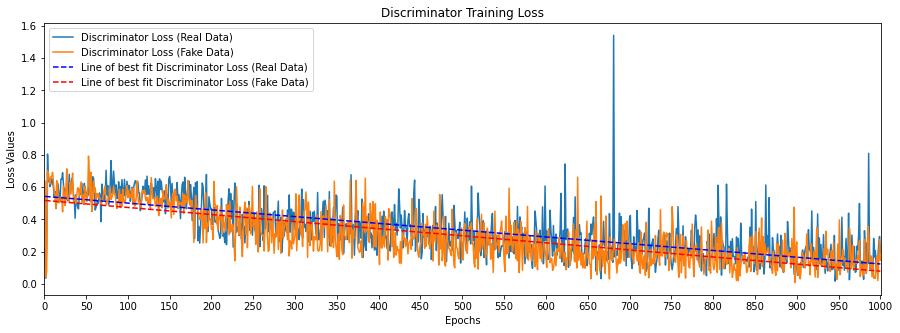

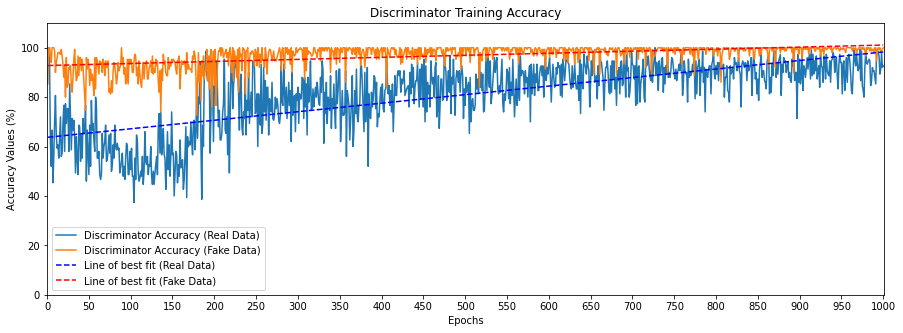

In [14]:
# Train GAN
def train_gan(generator, discriminator, gan_model, train_x, latent_dim, number_of_epochs=1000, batch_size=128):
    batches_per_epoch = int(train_x.shape[0] / batch_size)
    # Half of batch for real images and half for fake images
    half_batch_size = int(batch_size / 2)
    for i in range(number_of_epochs):
        # Loading bar for each batch in an epoch
        for j in tqdm(range(batches_per_epoch), desc='Epoch %d/%d' % (i+1, number_of_epochs)):
            # Select half_batch_size amount of random real samples from training data
            real_x, real_y = select_real_samples(train_x, half_batch_size)
            # Train discriminator on real images
            d_loss_real, _ = discriminator.train_on_batch(real_x, real_y)

            # Select half_batch_size amount of random fake samples from generated images
            fake_x, fake_y = generate_fake_samples(generator, latent_dim, half_batch_size)
            # Train discriminator on fake images
            d_loss_fake, _ = discriminator.train_on_batch(fake_x, fake_y)

            # Select batch_size amount of random points in the latent space
            gan_x = generate_latent_points(latent_dim, batch_size)
            # Inverted label for each image 
            gan_y = np.ones((batch_size, 1))
            # Update the generator via the discriminators erorr
            g_loss = gan_model.train_on_batch(gan_x, gan_y)
        print('Discriminator Loss (Real Data): %.3f, Discriminator Loss (Fake Data): %.3f, Generator Loss: %.3f' %
              (d_loss_real, d_loss_fake, g_loss))
        
        # Add data from each epoch to these arrays for plotting
        real_x, real_y = select_real_samples(train_x, 150)
        _, d_acc_real = discriminator.evaluate(real_x, real_y, verbose=0)

        fake_x, fake_y = generate_fake_samples(generator, latent_dim, 150)
        _, d_acc_fake = discriminator.evaluate(fake_x, fake_y, verbose=0)

        losses.append((d_loss_real, d_loss_fake))
        accuracies.append((100.0 * d_acc_real, 100.0 * d_acc_fake))
        epochs.append(i + 1)

        # Evaluate GAN every 10 epochs
        if (i + 1) % 10 == 0:
            save_generator(generator, i)
            evaluate_gan(i, generator, discriminator, train_x, latent_dim)

train_x = load_training_data()
train_gan(generator, discriminator, gan_model, train_x, latent_dim)
plot_loss_and_accuracy(losses, accuracies, epochs)